In [1]:
import warnings
warnings.filterwarnings('ignore')
import stwcs
import glob
import sys
import os
import shutil
import time
import filecmp
import astroquery
import progressbar
import copy
import requests
import random
import astropy.wcs as wcs
import numpy as np
from contextlib import contextmanager
from astropy import units as u
from astropy.utils.data import clear_download_cache,download_file
from astropy.io import fits
from astropy.table import Table, Column, unique
from astropy.time import Time
from astroscrappy import detect_cosmics
from stwcs import updatewcs
from scipy.interpolate import interp1d

# Internal dependencies
from common import Constants
from common import Options
from common import Settings
from common import Util
from nbutils import get_filter, get_instrument, get_chip, get_filter, input_list
from nbutils import get_zpt, add_visit_info, organize_reduction_tables, pick_deepest_images

@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

with suppress_stdout():
    from drizzlepac import tweakreg,astrodrizzle,catalogs,photeq
    from astroquery.mast import Observations
    from astropy.coordinates import SkyCoord

In [2]:
acceptable_filters = [
    'F220W','F250W','F330W','F344N','F435W','F475W','F550M','F555W',
    'F606W','F625W','F660N','F660N','F775W','F814W','F850LP','F892N',
    'F098M','F105W','F110W','F125W','F126N','F127M','F128N','F130N','F132N',
    'F139M','F140W','F153M','F160W','F164N','F167N','F200LP','F218W','F225W',
    'F275W','F280N','F300X','F336W','F343N','F350LP','F373N','F390M','F390W',
    'F395N','F410M','F438W','F467M','F469N','F475X','F487N','F547M',
    'F600LP','F621M','F625W','F631N','F645N','F656N','F657N','F658N','F665N',
    'F673N','F680N','F689M','F763M','F845M','F953N','F122M','F160BW','F185W',
    'F218W','F255W','F300W','F375N','F380W','F390N','F437N','F439W','F450W',
    'F569W','F588N','F622W','F631N','F673N','F675W','F702W','F785LP','F791W',
    'F953N','F1042M']

In [3]:
catalog_pars = {
    'skysigma':0.0,
    'computesig':True,
    'conv_width':3.5,
    'sharplo':0.2,
    'sharphi':1.0,
    'roundlo':-1.0,
    'roundhi':1.0,
    'peakmin':None,
    'peakmax':None,
    'fluxmin':None,
    'fluxmax':None,
    'nsigma':1.5,
    'ratio':1.0,
    'theta':0.0,
    'use_sharp_round': True,
    'expand_refcat': False,
    'enforce_user_order': True,
    'clean': True,
    'interactive': False,
    'verbose': False,
    'updatewcs': False,
    'xyunits': 'pixels',
    '_RULES_': {'_rule_1':'True', '_rule2_':'False'}
}

### Get obstable

In [4]:
workdir = '.'
input_images = [s for p in ['*flc.fits', '*flt.fits'] for s in glob.glob(os.path.join(workdir, p))]

In [5]:
obstable = input_list(input_images)

In [6]:
obstable = obstable[:12]

In [7]:
obstable

image,exptime,datetime,filter,instrument,detector,zeropoint,chip,imagenumber,visit,drizname
str20,float64,str19,str5,str12,str7,float64,int64,int64,int64,str99
./jbqz24u1q_flc.fits,480.0,2012-01-04T19:40:23,f606w,acs_wfc_full,acs_wfc,26.491376874932193,1,0,1,./acs.f606w.ut120104_0001.drz.fits
./jbqz24u3q_flc.fits,480.0,2012-01-04T19:51:01,f606w,acs_wfc_full,acs_wfc,26.491376874932193,1,0,1,./acs.f606w.ut120104_0001.drz.fits


### Tweakreg

In [8]:
def tweakreg_error(exception):
    message = '\n\n' + '#'*80 + '\n'
    message += 'WARNING: tweakreg failed: {e}\n'
    message += '#'*80 + '\n'
    print(message.format(e=exception.__class__.__name__))
    print('Error:', exception)
    print('Adjusting thresholds and images...')

In [9]:
# Apply TWEAKSUC header variable if tweakreg was successful
def apply_tweakreg_success(shifts):

    for row in shifts:
        if ~np.isnan(row['xoffset']) and ~np.isnan(row['yoffset']):
            file=row['file']
            if not os.path.exists(file):
                file=row['file']
                print(f'WARNING: {file} does not exist!')
                continue
            hdu = fits.open(file, mode='update')
            hdu[0].header['TWEAKSUC']=1
            hdu.close()

In [10]:
def check_images_for_tweakreg(run_images):

    if not run_images:
        return(None)

    images = copy.copy(run_images)

    for file in list(images):
        print('Checking {0} for TWEAKSUC=1'.format(file))
        hdu = fits.open(file, mode='readonly')
        remove_image = ('TWEAKSUC' in hdu[0].header.keys() and
            hdu[0].header['TWEAKSUC']==1)

        if remove_image:
            images.remove(file)

    # If run_images is now empty, return None instead
    if len(images)==0:
        return(None)

    return(images)

In [11]:
def fix_hdu_wcs_keys(image, change_keys, ref_url):

    hdu = fits.open(image, mode='update')
    ref = ref_url.strip('.old')
    outdir = '.'
    if not outdir:
        outdir = '.'

    for i,h in enumerate(hdu):
        for key in hdu[i].header.keys():
            if 'WCSNAME' in key:
                print('WCSNAME', hdu[i].header[key])
                hdu[i].header[key] = hdu[i].header[key].strip()
        for key in change_keys:
            if key in list(hdu[i].header.keys()):
                val = hdu[i].header[key]
                print(key, val)
            else:
                continue
            if val == 'N/A':
                continue
            if (ref+'$' in val):
                ref_file = val.split('$')[1]
            else:
                ref_file = val

            fullfile = os.path.join(outdir, ref_file)
            if not os.path.exists(fullfile):
                print(f'Grabbing: {fullfile}')
                # Try using both old cdbs database and new crds link
                urls = []
                url = 'https://hst-crds.stsci.edu/unchecked_get/references/hst/'
                urls.append(url+ref_file)

                url = 'ftp://ftp.stsci.edu/cdbs/'
                urls.append(url+ref_url+'/'+ref_file)

                for url in urls:
                    message = f'Downloading file: {url}'
                    sys.stdout.write(message)
                    sys.stdout.flush()
                    try:
                        dat = download_file(url, cache=False,
                            show_progress=False, timeout=120)
                        shutil.move(dat, fullfile)
                        message = '\r' + message
                        message += Constants.green+' [SUCCESS]'+Constants.end+'\n'
                        sys.stdout.write(message)
                        break
                    except:
                        message = '\r' + message
                        message += Constants.red+' [FAILURE]'+Constants.end+'\n'
                        sys.stdout.write(message)
                        print(message)

            message = f'Setting {image},{i} {key}={fullfile}'
            print(message)
            hdu[i].header[key] = fullfile

        # WFPC2 does not have residual distortion corrections and astrodrizzle
        # choke if DGEOFILE is in header but not NPOLFILE.  So do a final check
        # for this part of the WCS keys
        if 'wfpc2' in get_instrument(image).lower():
            keys = list(h.header.keys())
            if 'DGEOFILE' in keys and 'NPOLFILE' not in keys:
                del hdu[i].header['DGEOFILE']

    hdu.writeto(image, overwrite=True, output_verify='silentfix')
    hdu.close()

In [12]:
def fix_idcscale(image):

    det = '_'.join(get_instrument(image).split('_')[:2])

    if 'wfc3' in det:
        hdu = fits.open(image)
        idcscale = 0.1282500028610229
        for i,h in enumerate(hdu):
            if 'IDCSCALE' not in hdu[i].header.keys():
                hdu[i].header['IDCSCALE']=idcscale

        hdu.writeto(image, overwrite=True, output_verify='silentfix')

In [13]:
# Update image wcs using updatewcs routine
def update_image_wcs(image, use_db=True):

    hdu = fits.open(image, mode='readonly')
    # Check if tweakreg was successfully run.  If so, then skip
    if 'TWEAKSUC' in hdu[0].header.keys() and hdu[0].header['TWEAKSUC']==1:
        return(True)

    # Check for hierarchical alignment.  If image has been shifted with
    # hierarchical alignment, we don't want to shift it again
    if 'HIERARCH' in hdu[0].header.keys() and hdu[0].header['HIERARCH']==1:
        return(True)

    hdu.close()

    message = 'Updating WCS for {file}'
    print(message.format(file=image))

#     self.clear_downloads(self.options['global_defaults'])

    change_keys = ['IDCTAB','DGEOFILE','NPOLEXT','NPOLFILE','D2IMFILE', 'D2IMEXT','OFFTAB']
    inst = get_instrument(image).split('_')[0]
    ref_url = 'jref.old'

    fix_hdu_wcs_keys(image, change_keys, ref_url)

    # Usually if updatewcs fails, that means it's already been done
    try:
        updatewcs.updatewcs(image, use_db=use_db) #probably not needed for jwst
        hdu = fits.open(image, mode='update')
        message = '\n\nupdatewcs success.  File info:'
        print(message)
        hdu.info()
        hdu.close()
        fix_hdu_wcs_keys(image, change_keys, ref_url)
        fix_idcscale(image)
        return(True)
    except:
        error = 'ERROR: failed to update WCS for image {file}'
        print(error.format(file=image))
        return(None)

In [14]:
def run_cosmic(image, options, output=None):
    message = 'Cleaning cosmic rays in image: {image}'
    print(message.format(image=image))
    hdulist = fits.open(image,mode='readonly')

    if output is None:
        output = image

    for i,hdu in enumerate(hdulist):
        if hdu.name=='SCI':
            mask = np.zeros(hdu.data.shape, dtype=np.bool_)

            crmask, crclean = detect_cosmics(hdu.data.copy().astype('<f4'),
                inmask=mask, readnoise=options['rdnoise'], gain=options['gain'],
                satlevel=options['saturate'], sigclip=options['sig_clip'],
                sigfrac=options['sig_frac'], objlim=options['obj_lim'])

            hdulist[i].data[:,:] = crclean[:,:]

            # Add crmask data to DQ array or DQ image
            if False:
                if 'flc' in image or 'flt' in image:
                    # Assume this hdu is corresponding DQ array
                    if len(hdulist)>=i+2 and hdulist[i+2].name=='DQ':
                        hdulist[i+2].data[np.where(crmask)]=4096
                elif 'c0m' in image:
                    maskfile = image.split('_')[0]+'_c1m.fits'
                    if os.path.exists(maskfile):
                        maskhdu = fits.open(maskfile)
                        maskhdu[i].data[np.where(crmask)]=4096
                        maskhdu.writeto(maskfile, overwrite=True)

    # This writes in place
    hdulist.writeto(output, overwrite=True, output_verify='silentfix')
    hdulist.close()

In [15]:
def get_nsources(image, thresh):
    imghdu = fits.open(image)
    nsources = 0
    message = '\n\nGetting number of sources in {im} at threshold={thresh}'
    print(message.format(im=image, thresh=thresh))
    for i,h in enumerate(imghdu):
        if h.name=='SCI' or (len(imghdu)==1 and h.name=='PRIMARY'):
            filename="{:s}[{:d}]".format(image, i)
            wcs = stwcs.wcsutil.HSTWCS(filename)
            catalog_mode = 'automatic'
            catalog = catalogs.generateCatalog(wcs, mode=catalog_mode,
                catalog=filename, threshold=thresh,
                **catalog_pars)
            try:
                catalog.buildCatalogs()
                nsources += catalog.num_objects
            except:
                pass

    message = 'Got {n} total sources'
    print(message.format(n=nsources))

    return(nsources)

def count_nsources(images):
    cat_str = '_sci*_xy_catalog.coo'
    # Tag cat files with the threshold so we can reference it later
    n = 0
    for image in images:
        for catalog in glob.glob(image.replace('.fits',cat_str)):
            with open(catalog, 'r+') as f:
                for line in f:
                    if 'threshold' not in line:
                        n += 1

    return(n)

# Given an input image, look for a matching catalog and estimate what the
# threshold should be for this image.  If no catalog exists, generate one
# on the fly and estimate threshold
def get_tweakreg_thresholds(image, target):

    message = 'Getting tweakreg threshold for {im}.  Target nobj={t}'
    print(message.format(im=image, t=target))

    inp_data = []
    # Cascade down in S/N threshold until we exceed the target number of objs
    for t in np.flip([3.0,4.0,5.0,6.0,8.0,10.0,15.0,20.0,25.0,30.0,40.0,80.0]):
        nobj = get_nsources(image, t)
        # If no data yet, just add and continue
        if len(inp_data)<3:
            inp_data.append((float(nobj), float(t)))
        # If we're going backward - i.e., more objects than last run, then
        # just break
        elif nobj < inp_data[-1][0]:
            break
        else:
            # Otherwise, add the data and if we've already hit the target then
            # break
            inp_data.append((float(nobj), float(t)))
            if nobj > target: break

    return(inp_data)

def add_thresh_data(thresh_data, image, inp_data):
    if not thresh_data:
        keys = []
        data = []
        for val in inp_data:
            keys.append('%2.1f'%float(val[1]))
            data.append([val[0]])

        keys.insert(0, 'file')
        data.insert(0, [image])

        thresh_data = Table(data, names=keys)
        return(thresh_data)

    keys = []
    data = []
    for val in inp_data:
        key = '%2.1f'%float(val[1])
        keys.append(key)
        data.append(float(val[0]))
        if key not in thresh_data.keys():
            thresh_data.add_column(Column([np.nan]*len(thresh_data),
                name=key))

    keys.insert(0, 'file')
    data.insert(0, image)

    # Recast as table to prevent complaint aobut thresh_data.keys()
    thresh_data = Table(thresh_data)

    for key in thresh_data.keys():
        if key not in keys:
            data.append(np.nan)

    thresh_data.add_row(data)
    return(thresh_data)

def get_best_tweakreg_threshold(thresh_data, target):

    thresh = []
    nsources = []
    thresh_data = Table(thresh_data)
    for key in thresh_data.keys():
        if key=='file': continue
        thresh.append(float(key))
        nsources.append(float(thresh_data[key]))

    thresh = np.array(thresh)
    nsources = np.array(nsources)

    mask = (~np.isnan(thresh)) & (~np.isnan(nsources))
    thresh = thresh[mask]
    nsources = nsources[mask]

    # Interpolate the data and check what S/N target we want to get obj number
    thresh_func = interp1d(nsources, thresh, kind='linear', bounds_error=False,
        fill_value='extrapolate')
    threshold = thresh_func(target)

    # Set minimum and maximum threshold
    if threshold<3.0: threshold=3.0
    if threshold>1000.0: threshold=1000.0

    message = 'Using threshold: {t}'
    print(message.format(t=threshold))

    return(threshold)

In [21]:
test_image = tmp_images[0]

In [66]:
inp_data = get_tweakreg_thresholds('dummy.fits', 4000*4)
thresh_data = None
thresh_data = add_thresh_data(thresh_data, 'dummy.fits', inp_data)

Getting tweakreg threshold for dummy.fits.  Target nobj=16000


Getting number of sources in dummy.fits at threshold=80.0
  #  Source finding for 'dummy.fits', EXT=('SCI', 1) started at: 00:17:15.103 (03/07/2024)
     Found 16 objects.
  #  Source finding for 'dummy.fits', EXT=('SCI', 2) started at: 00:17:15.551 (03/07/2024)
     Found 41 objects.
Got 57 total sources


Getting number of sources in dummy.fits at threshold=40.0
  #  Source finding for 'dummy.fits', EXT=('SCI', 1) started at: 00:17:15.978 (03/07/2024)
     Found 30 objects.
  #  Source finding for 'dummy.fits', EXT=('SCI', 2) started at: 00:17:16.411 (03/07/2024)
     Found 57 objects.
Got 87 total sources


Getting number of sources in dummy.fits at threshold=30.0
  #  Source finding for 'dummy.fits', EXT=('SCI', 1) started at: 00:17:16.844 (03/07/2024)
     Found 42 objects.
  #  Source finding for 'dummy.fits', EXT=('SCI', 2) started at: 00:17:17.269 (03/07/2024)
     Found 67 objects.
Got 109 total sources


Getting 

In [67]:
thresh_data

file,80.0,40.0,30.0,25.0,20.0,15.0,10.0,8.0,6.0,5.0,4.0
str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
dummy.fits,57.0,87.0,109.0,123.0,157.0,202.0,314.0,441.0,2734.0,11930.0,46804.0


In [16]:
outdir = '.'
reference = ''
run_images = list(obstable['image'])
shift_table = Table([run_images, [np.nan]*len(run_images), 
                     [np.nan]*len(run_images)], names = ('file', 'xoffset', 'yoffset'))
tmp_images = []

In [18]:
# updates wcs, probably not needed for jwst/nircam
for image in run_images:
    if True and not False:
        det = '_'.join(get_instrument(image).split('_')[:2])
        update_image_wcs(image)

Updating WCS for ./jbqz24u1q_flc.fits
IDCTAB ./4bb1536cj_idc.fits
Grabbing: ././4bb1536cj_idc.fits
Setting ./jbqz24u1q_flc.fits,0 IDCTAB=././4bb1536cj_idc.fits
DGEOFILE ./qbu16424j_dxy.fits
Grabbing: ././qbu16424j_dxy.fits
Setting ./jbqz24u1q_flc.fits,0 DGEOFILE=././qbu16424j_dxy.fits
NPOLFILE ./4bb1536ej_npl.fits
Grabbing: ././4bb1536ej_npl.fits
Setting ./jbqz24u1q_flc.fits,0 NPOLFILE=././4bb1536ej_npl.fits
D2IMFILE ./4bb15371j_d2i.fits
Grabbing: ././4bb15371j_d2i.fits
Setting ./jbqz24u1q_flc.fits,0 D2IMFILE=././4bb15371j_d2i.fits
WCSNAME OPUS
WCSNAME IDC_4bb1536cj-GSC240
WCSNAME IDC_4bb1536cj
WCSNAME IDC_4bb1536cj-GSC240-1
WCSNAME IDC_4bb1536cj-GSC240
IDCTAB ./4bb1536cj_idc.fits
Setting ./jbqz24u1q_flc.fits,1 IDCTAB=././4bb1536cj_idc.fits
NPOLEXT ./4bb1536ej_npl.fits
Setting ./jbqz24u1q_flc.fits,1 NPOLEXT=././4bb1536ej_npl.fits
D2IMEXT ./4bb15371j_d2i.fits
Setting ./jbqz24u1q_flc.fits,1 D2IMEXT=././4bb15371j_d2i.fits
WCSNAME IDC_4bb1536cj
WCSNAME IDC_4bb1536cj
WCSNAME OPUS
WCSNAME ID

Processing /home/aswin/hst123/jbqz24u1q_flc.fits['SCI',1]
Updating header for /home/aswin/hst123/jbqz24u1q_flc.fits[1]
Processing /home/aswin/hst123/jbqz24u1q_flc.fits['SCI',2]
Updating header for /home/aswin/hst123/jbqz24u1q_flc.fits[4]
Writing out a priori WCS IDC_4bb1536cj-GSC240 to headerlet file: jbqz24u1q_flc_9ec245_hlet.fits




updatewcs success.  File info:
Filename: ./jbqz24u1q_flc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     285   ()      
  1  SCI           1 ImageHDU       263   (4096, 2048)   float32   
  2  ERR           1 ImageHDU        55   (4096, 2048)   float32   
  3  DQ            1 ImageHDU        47   (4096, 2048)   int16   
  4  SCI           2 ImageHDU       261   (4096, 2048)   float32   
  5  ERR           2 ImageHDU        55   (4096, 2048)   float32   
  6  DQ            2 ImageHDU        47   (4096, 2048)   int16   
  7  D2IMARR       1 ImageHDU        16   (64, 32)   float32   
  8  D2IMARR       2 ImageHDU        16   (64, 32)   float32   
  9  D2IMARR       3 ImageHDU        16   (64, 32)   float32   
 10  D2IMARR       4 ImageHDU        16   (64, 32)   float32   
 11  WCSDVARR      1 ImageHDU        16   (64, 32)   float32   
 12  WCSDVARR      2 ImageHDU        16   (64, 32)   float32   
 13  WCSDVARR      3 ImageHDU      

Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/jbqz24u3q
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "OPUS" for observation "jbqz24u3q"
Retrieving astrometrically-updated WCS "IDC_0461802dj" for observation "jbqz24u3q"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "jbqz24u3q"
Retrieving astrometrically-updated WCS "IDC_0461802dj-GSC240" for observation "jbqz24u3q"
Retrieving astrometrically-updated WCS "OPUS-HSC30" for observation "jbqz24u3q"
Retrieving astrometrically-updated WCS "IDC_0461802dj-HSC30" for observation "jbqz24u3q"
Retrieving astrometrically-updated WCS "IDC_0461802dj-FIT_REL_GAIADR1" for observation "jbqz24u3q"
Retrieving astrometrically-updated WCS "jbqz24u3q_flt_IDC_0461802dj-HSC30-hlet.fits" for observation "jbqz24u3q"
Retrieving astrometrically-updated WCS "IDC_0461802dj-FIT_REL_GAIADR2" for observation "jbqz24u3q"
Retrieving astrometrically-updated WCS "IDC_0461802d



updatewcs success.  File info:
Filename: ./jbqz24u3q_flc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     285   ()      
  1  SCI           1 ImageHDU       263   (4096, 2048)   float32   
  2  ERR           1 ImageHDU        55   (4096, 2048)   float32   
  3  DQ            1 ImageHDU        47   (4096, 2048)   int16   
  4  SCI           2 ImageHDU       261   (4096, 2048)   float32   
  5  ERR           2 ImageHDU        55   (4096, 2048)   float32   
  6  DQ            2 ImageHDU        47   (4096, 2048)   int16   
  7  D2IMARR       1 ImageHDU        16   (64, 32)   float32   
  8  D2IMARR       2 ImageHDU        16   (64, 32)   float32   
  9  D2IMARR       3 ImageHDU        16   (64, 32)   float32   
 10  D2IMARR       4 ImageHDU        16   (64, 32)   float32   
 11  WCSDVARR      1 ImageHDU        16   (64, 32)   float32   
 12  WCSDVARR      2 ImageHDU        16   (64, 32)   float32   
 13  WCSDVARR      3 ImageHDU      

In [17]:
# runs cosmic ray correction, probably not needed for jwst/nircam
for image in run_images:
        rawtmp = image.replace('.fits','.rawtmp.fits')
        tmp_images.append(rawtmp)
        
        # Check if rawtmp already exists
        if os.path.exists(rawtmp):
            message = '{file} exists. Skipping...'
            print(message.format(file=rawtmp))
            continue
        
        # Copy the raw data into a temporary file
        shutil.copyfile(image, rawtmp)

        # Clean cosmic rays so they aren't used for alignment
        inst = get_instrument(image).split('_')[0]
        crpars = {'rdnoise': 6.5,
                  'gain': 1.0,
                  'saturate': 70000.0,
                  'sig_clip': 3.0,
                  'sig_frac': 0.1,
                  'obj_lim': 5.0}
        run_cosmic(rawtmp, crpars)

./jbqz24u1q_flc.rawtmp.fits exists. Skipping...
./jbqz24u3q_flc.rawtmp.fits exists. Skipping...


In [18]:
twim = check_images_for_tweakreg(tmp_images)

Checking ./jbqz24u1q_flc.rawtmp.fits for TWEAKSUC=1
Checking ./jbqz24u3q_flc.rawtmp.fits for TWEAKSUC=1


In [19]:
list(set(twim) ^ set(tmp_images))

[]

In [18]:
modified = False
ref_images = pick_deepest_images(tmp_images)
deepest = sorted(ref_images, key=lambda im: fits.getval(im, 'EXPTIME'))[-1]
if (not reference or reference=='dummy.fits'):
    reference = 'dummy.fits'
    message = 'Copying {deep} to reference dummy.fits'
    print(message.format(deep=deepest))
    shutil.copyfile(deepest, reference)
elif not self.prepare_reference_tweakreg(reference):
    # Can't use this reference image, just use one of the input
    reference = 'dummy.fits'
    message = 'Copying {deep} to reference dummy.fits'
    print(message.format(deep=deepest))
    shutil.copyfile(deepest, reference)
else:
    modified = True

message = 'Tweakreg is executing...'
print(message)

Copying ./jbqz24u3q_flc.rawtmp.fits to reference dummy.fits
Tweakreg is executing...


In [ ]:
tweakreg.TweakReg(files=['./jbqz24u1q_flc.rawtmp.fits'], refimage='dummy.fits',
    verbose=False, interactive=False, clean=True,
    writecat=True, updatehdr=True, reusename=True,
    rfluxunits='counts', minobj=10, wcsname='TWEAK',
    searchrad=1, searchunits='arcseconds', runfile='',
    tolerance=0.25, refnbright=4000, nbright=4000,
    separation=0.5, residplot='No plot', see2dplot=False,
    fitgeometry='shift',
    imagefindcfg = {'threshold': 4.8481,
        'conv_width': 3.5, 'use_sharp_round': True},
    refimagefindcfg = {'threshold': 4.8833,
        'conv_width': 3.5, 'use_sharp_round': True},
    shiftfile=True, outshifts='./drizzle_shifts.txt')

No trailer file created...
TweakReg Version 3.5.1 started at: 18:14:42.621 (10/07/2024) 

Version Information
--------------------
Python Version 3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]
numpy Version -> 1.24.3 
astropy Version -> 6.1.0 
stwcs Version -> 1.7.2 
photutils Version -> 1.12.0 

Finding shifts for: 
    /home/aswin/hst123/jbqz24u1q_flc.rawtmp.fits

===  Source finding for image '/home/aswin/hst123/jbqz24u1q_flc.rawtmp.fits':
  #  Source finding for '/home/aswin/hst123/jbqz24u1q_flc.rawtmp.fits', EXT=('SCI', 1) started at: 18:14:42.767 (10/07/2024)
     Found 6470 objects.
  #  Source finding for '/home/aswin/hst123/jbqz24u1q_flc.rawtmp.fits', EXT=('SCI', 2) started at: 18:14:44.271 (10/07/2024)
     Found 7256 objects.
===  FINAL number of objects in image '/home/aswin/hst123/jbqz24u1q_flc.rawtmp.fits': 13726

===  Source finding for image 'dummy.fits':
  #  Source finding for 'dummy.fits', EXT=('SCI', 1) started at: 18:14:46.39 (10/07/2024)
     Found 6576 object

In [19]:
start_tweak = time.time()

tweakreg_success = False
tweak_img = copy.copy(['./jbqz24u1q_flc.rawtmp.fits']) #copy.copy(tmp_images)
ithresh = 10 ; rthresh = 10
shallow_img = []
thresh_data = None
tries = 0
nbr = 4000

while (not tweakreg_success and tries < 10):
    tweak_img = check_images_for_tweakreg(tweak_img)
    if not tweak_img: break
    if tweak_img:
        # Remove images from tweak_img if they are too shallow
        if shallow_img:
            for img in shallow_img:
                if img in tweak_img:
                    tweak_img.remove(img)

        if len(tweak_img)==0:
            error = 'ERROR: removed all images as shallow'
            print(error)
            tweak_img = copy.copy(tmp_images)
            tweak_img = check_images_for_tweakreg(tweak_img)

        # If we've tried multiple runs and there are images in input
        # list with TWEAKSUC and reference image=dummy.fits, we might need
        # to try a different reference image
        success = list(set(tmp_images) ^ set(tweak_img))
        if tries > 1 and reference=='dummy.fits' and len(success)>0:
            # Make random success image new dummy image
            n = len(success)-1
            shutil.copyfile(success[random.randint(0,n)],'dummy.fits')

        # This estimates what the input threshold should be and cuts
        # out images based on number of detected sources from previous
        # rounds of tweakreg
        message = '\n\nReference image: {ref} \n'
        message += 'Images: {im}'
        print(message.format(ref=reference, im=','.join(tweak_img)))

        # Get deepest image and use threshold from that
        deepest = sorted(tweak_img,
            key=lambda im: fits.getval(im, 'EXPTIME'))[-1]

        if not thresh_data or deepest not in thresh_data['file']:
            inp_data = get_tweakreg_thresholds(deepest, nbr*4)
            thresh_data = add_thresh_data(thresh_data, deepest, inp_data)
        mask = thresh_data['file']==deepest
        inp_thresh = thresh_data[mask][0]
        print('Getting image threshold...')
        new_ithresh = get_best_tweakreg_threshold(inp_thresh, nbr*4)

        if not thresh_data or reference not in thresh_data['file']:
            inp_data = get_tweakreg_thresholds(reference, nbr*4)
            thresh_data = add_thresh_data(thresh_data, reference, inp_data)
        mask = thresh_data['file']==reference
        inp_thresh = thresh_data[mask][0]
        print('Getting reference threshold...')
        new_rthresh = get_best_tweakreg_threshold(inp_thresh, nbr*4)

        if not rthresh: rthresh = 10
        if not ithresh: ithresh = 10

        # Other input options
        nbright = nbr
        minobj = 10
        search_rad = int(np.round(1.0))
#         if search_radius: search_rad = search_radius

        rconv = 3.5 ; iconv = 3.5 ; tol = 0.25
        if 'wfc3_ir' in get_instrument(reference):
            rconv = 2.5
        if all(['wfc3_ir' in get_instrument(i)
            for i in tweak_img]):
            iconv = 2.5 ; tol = 0.6
        if 'wfpc2' in get_instrument(reference):
            rconv = 2.5
        if all(['wfpc2' in get_instrument(i)
            for i in tweak_img]):
            iconv = 2.5 ; tol = 0.5


        # Don't want to keep trying same thing over and over
        if (new_ithresh>=ithresh or new_rthresh>=rthresh) and tries>1:
            # Decrease the threshold and increase tolerance
            message = 'Decreasing threshold and increasing tolerance...'
            print(message)
            ithresh = np.max([new_ithresh*(0.95**tries), 3.0])
            rthresh = np.max([new_rthresh*(0.95**tries), 3.0])
            tol = tol * 1.3**tries
            search_rad = search_rad * 1.2**tries
        else:
            ithresh = new_ithresh
            rthresh = new_rthresh

        if tries > 7:
            minobj = 7

        message = '\nAdjusting thresholds:\n'
        message += 'Reference threshold={rthresh}\n'
        message += 'Image threshold={ithresh}\n'
        message += 'Tolerance={tol}\n'
        message += 'Search radius={rad}\n'
        print(message.format(ithresh='%2.4f'%ithresh,
            rthresh='%2.4f'%rthresh, tol='%2.4f'%tol,
            rad='%2.4f'%search_rad))

        outshifts = os.path.join(outdir, 'drizzle_shifts.txt')

        try:
            tweakreg.TweakReg(files=tweak_img, refimage=reference,
                verbose=False, interactive=False, clean=True,
                writecat=True, updatehdr=True, reusename=True,
                rfluxunits='counts', minobj=minobj, wcsname='TWEAK',
                searchrad=search_rad, searchunits='arcseconds', runfile='',
                tolerance=tol, refnbright=nbright, nbright=nbright,
                separation=0.5, residplot='No plot', see2dplot=False,
                fitgeometry='shift',
                imagefindcfg = {'threshold': ithresh,
                    'conv_width': iconv, 'use_sharp_round': True},
                refimagefindcfg = {'threshold': rthresh,
                    'conv_width': rconv, 'use_sharp_round': True},
                shiftfile=True, outshifts=outshifts)

            # Reset shallow_img list
            shallow_img = []

        except AssertionError as e:
            tweakreg_error(e)

            message = 'Re-running tweakreg with shallow images removed:'
            print(message)
            for img in tweak_img:
                nsources = get_nsources(img, ithresh)
                if nsources < 1000:
                    shallow_img.append(img)

        # Occurs when all images fail alignment
        except TypeError as e:
            tweakreg_error(e)

        # Record what the shifts are for each of the files run
        message='Reading in shift file: {file}'
        print(message.format(file=outshifts))
        shifts = Table.read(outshifts, format='ascii', names=('file',
            'xoffset','yoffset','rotation1','rotation2','scale1','scale2'))

        apply_tweakreg_success(shifts)

        # Add data from output shiftfile to shift_table
        for row in shifts:
            filename = os.path.basename(row['file'])
            filename = filename.replace('.rawtmp.fits','')
            filename = filename.replace('.fits','')

            idx = [i for i,row in enumerate(shift_table)
                if filename in row['file']]

            if len(idx)==1:
                shift_table[idx[0]]['xoffset']=row['xoffset']
                shift_table[idx[0]]['yoffset']=row['yoffset']

        if not check_images_for_tweakreg(tmp_images):
            tweakreg_success = True

        tries += 1

message = 'Tweakreg took {time} seconds to execute.\n\n'
print(message.format(time = time.time()-start_tweak))

print(shift_table)

Checking ./jbqz24u1q_flc.rawtmp.fits for TWEAKSUC=1


Reference image: dummy.fits 
Images: ./jbqz24u1q_flc.rawtmp.fits
Getting tweakreg threshold for ./jbqz24u1q_flc.rawtmp.fits.  Target nobj=16000


Getting number of sources in ./jbqz24u1q_flc.rawtmp.fits at threshold=80.0
  #  Source finding for './jbqz24u1q_flc.rawtmp.fits', EXT=('SCI', 1) started at: 18:16:19.003 (10/07/2024)
     Found 16 objects.
  #  Source finding for './jbqz24u1q_flc.rawtmp.fits', EXT=('SCI', 2) started at: 18:16:19.462 (10/07/2024)
     Found 35 objects.
Got 51 total sources


Getting number of sources in ./jbqz24u1q_flc.rawtmp.fits at threshold=40.0
  #  Source finding for './jbqz24u1q_flc.rawtmp.fits', EXT=('SCI', 1) started at: 18:16:19.909 (10/07/2024)
     Found 35 objects.
  #  Source finding for './jbqz24u1q_flc.rawtmp.fits', EXT=('SCI', 2) started at: 18:16:20.356 (10/07/2024)
     Found 65 objects.
Got 100 total sources


Getting number of sources in ./jbqz24u1q_flc.rawtmp.fits at threshold=30.0
  # 

  #  Source finding for '/home/aswin/hst123/jbqz24u1q_flc.rawtmp.fits', EXT=('SCI', 1) started at: 18:17:03.711 (10/07/2024)
     Found 6470 objects.
  #  Source finding for '/home/aswin/hst123/jbqz24u1q_flc.rawtmp.fits', EXT=('SCI', 2) started at: 18:17:05.607 (10/07/2024)
     Found 7256 objects.
===  FINAL number of objects in image '/home/aswin/hst123/jbqz24u1q_flc.rawtmp.fits': 13726

===  Source finding for image 'dummy.fits':
  #  Source finding for 'dummy.fits', EXT=('SCI', 1) started at: 18:17:08.352 (10/07/2024)
     Found 6577 objects.
  #  Source finding for 'dummy.fits', EXT=('SCI', 2) started at: 18:17:10.216 (10/07/2024)
     Found 7726 objects.
===  FINAL number of objects in image 'dummy.fits': 14303


Performing alignment in the projection plane defined by the WCS
derived from 'dummy.fits'


Performing fit for: /home/aswin/hst123/jbqz24u1q_flc.rawtmp.fits

Matching sources from '/home/aswin/hst123/jbqz24u1q_flc.rawtmp.fits' with sources from reference image 'dummy.fit

In [20]:
import jhat
from jhat import hst_photclass,st_wcs_align

In [23]:
hst_phot = hst_photclass(psf_fwhm=1.8,aperture_radius=5)
hst_phot.run_phot(imagename='jbqz24u3q_flc.fits',photfilename='auto',overwrite=True)
ref_catname = 'jbqz24u3q_flc.fits'.replace('.fits','.phot.txt') # the default
refcat = Table.read(ref_catname,format='ascii')
print(refcat)

2024-07-10 18:30:30,422 - stpipe - INFO - Setting up logfile :  astrodrizzle.log


0 jbqz24u3q_flc.phot.txt
Setting up logfile :  astrodrizzle.log


2024-07-10 18:30:30,423 - stpipe - INFO - AstroDrizzle log file: astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


2024-07-10 18:30:30,426 - stpipe - INFO - AstroDrizzle Version 3.5.1 started at: 18:30:30.426 (10/07/2024)


AstroDrizzle Version 3.5.1 started at: 18:30:30.426 (10/07/2024)


2024-07-10 18:30:30,428 - stpipe - INFO - 


2024-07-10 18:30:30,429 - stpipe - INFO - Version Information
2024-07-10 18:30:30,430 - stpipe - INFO - --------------------
2024-07-10 18:30:30,432 - stpipe - INFO - Python Version 3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]
2024-07-10 18:30:30,433 - stpipe - INFO - numpy Version -> 1.24.3 
2024-07-10 18:30:30,433 - stpipe - INFO - astropy Version -> 6.1.0 
2024-07-10 18:30:30,434 - stpipe - INFO - stwcs Version -> 1.7.2 
2024-07-10 18:30:30,435 - stpipe - INFO - photutils Version -> 1.12.0 
2024-07-10 18:30:30,436 - stpipe - INFO - ==== Processing Step  Initialization  started at  18:30:30.436 (10/07/2024)


==== Processing Step  Initialization  started at  18:30:30.436 (10/07/2024)


2024-07-10 18:30:30,437 - stpipe - INFO - 


2024-07-10 18:30:30,466 - stpipe - INFO - Executing serially
2024-07-10 18:30:30,501 - stpipe - INFO - Setting up output name: jbqz24u3q_drc.fits
2024-07-10 18:30:30,502 - stpipe - INFO - -Creating imageObject List as input for processing steps.
2024-07-10 18:30:30,635 - stpipe - INFO - Reading in MDRIZSKY of 31.831167221069336
2024-07-10 18:30:30,683 - stpipe - INFO - Reading in MDRIZSKY of 31.831167221069336
2024-07-10 18:30:30,727 - stpipe - INFO - Reset bit values of 4096 to a value of 0 in jbqz24u3q_flc.fits[DQ,1]
2024-07-10 18:30:30,790 - stpipe - INFO - Reset bit values of 4096 to a value of 0 in jbqz24u3q_flc.fits[DQ,2]
2024-07-10 18:30:30,813 - stpipe - INFO - -Creating output WCS.
2024-07-10 18:30:30,818 - stpipe - INFO - WCS Keywords


WCS Keywords


2024-07-10 18:30:30,819 - stpipe - INFO - 


2024-07-10 18:30:30,820 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-07-10 18:30:30,822 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-07-10 18:30:30,823 - stpipe - INFO - CRVAL : 31.41725855258812 -58.52166529828469 


CRVAL : 31.41725855258812 -58.52166529828469 


2024-07-10 18:30:30,826 - stpipe - INFO - CRPIX : 2107.0 2118.5 


CRPIX : 2107.0 2118.5 


2024-07-10 18:30:30,827 - stpipe - INFO - CD1_1 CD1_2  : -6.079543684976387e-06 1.2487609184722468e-05 


CD1_1 CD1_2  : -6.079543684976387e-06 1.2487609184722468e-05 


2024-07-10 18:30:30,828 - stpipe - INFO - CD2_1 CD2_2  : 1.2487609184722468e-05 6.079543684976387e-06 


CD2_1 CD2_2  : 1.2487609184722468e-05 6.079543684976387e-06 


2024-07-10 18:30:30,831 - stpipe - INFO - NAXIS : 4214  4237


NAXIS : 4214  4237


2024-07-10 18:30:30,832 - stpipe - INFO - ********************************************************************************


********************************************************************************


2024-07-10 18:30:30,833 - stpipe - INFO - *


*


2024-07-10 18:30:30,834 - stpipe - INFO - *  Estimated memory usage:  up to 268 Mb.


*  Estimated memory usage:  up to 268 Mb.


2024-07-10 18:30:30,835 - stpipe - INFO - *  Output image size:       4214 X 4237 pixels. 


*  Output image size:       4214 X 4237 pixels. 


2024-07-10 18:30:30,837 - stpipe - INFO - *  Output image file:       ~ 204 Mb. 


*  Output image file:       ~ 204 Mb. 


2024-07-10 18:30:30,838 - stpipe - INFO - *  Cores available:         1


*  Cores available:         1


2024-07-10 18:30:30,839 - stpipe - INFO - *


*


2024-07-10 18:30:30,840 - stpipe - INFO - ********************************************************************************


********************************************************************************


2024-07-10 18:30:30,841 - stpipe - INFO - ==== Processing Step Initialization finished at 18:30:30.841 (10/07/2024)


==== Processing Step Initialization finished at 18:30:30.841 (10/07/2024)


2024-07-10 18:30:30,843 - stpipe - INFO - USER INPUT PARAMETERS common to all Processing Steps:
2024-07-10 18:30:30,844 - stpipe - INFO - 	build :	False
2024-07-10 18:30:30,845 - stpipe - INFO - 	coeffs :	True
2024-07-10 18:30:30,846 - stpipe - INFO - 	context :	True
2024-07-10 18:30:30,847 - stpipe - INFO - 	crbit :	4096
2024-07-10 18:30:30,849 - stpipe - INFO - 	group :	
2024-07-10 18:30:30,849 - stpipe - INFO - 	in_memory :	False
2024-07-10 18:30:30,850 - stpipe - INFO - 	input :	jbqz24u3q_flc.fits
2024-07-10 18:30:30,850 - stpipe - INFO - 	mdriztab :	False
2024-07-10 18:30:30,851 - stpipe - INFO - 	num_cores :	None
2024-07-10 18:30:30,851 - stpipe - INFO - 	output :	
2024-07-10 18:30:30,852 - stpipe - INFO - 	proc_unit :	native
2024-07-10 18:30:30,852 - stpipe - INFO - 	resetbits :	4096
2024-07-10 18:30:30,853 - stpipe - INFO - 	rules_file :	
2024-07-10 18:30:30,853 - stpipe - INFO - 	runfile :	astrodrizzle.log
2024-07-10 18:30:30,853 - stpipe - INFO - 	stepsize :	10
2024-07-10 18:

==== Processing Step  Static Mask  started at  18:30:30.855 (10/07/2024)


2024-07-10 18:30:30,856 - stpipe - INFO - 


2024-07-10 18:30:30,857 - stpipe - INFO - USER INPUT PARAMETERS for Static Mask Step:
2024-07-10 18:30:30,859 - stpipe - INFO - 	static :	True
2024-07-10 18:30:30,860 - stpipe - INFO - 	static_sig :	4.0
2024-07-10 18:30:30,860 - stpipe - INFO - Computing static mask:

2024-07-10 18:30:31,047 - stpipe - INFO -   mode = 31.159400;   rms = 8.546517;   static_sig = 4.00
2024-07-10 18:30:31,229 - stpipe - INFO -   mode = 31.213149;   rms = 8.912493;   static_sig = 4.00
2024-07-10 18:30:31,264 - stpipe - INFO - Saving static mask to disk: ./_2048x4096_1_staticMask.fits
2024-07-10 18:30:31,284 - stpipe - INFO - Saving static mask to disk: ./_2048x4096_2_staticMask.fits
2024-07-10 18:30:31,285 - stpipe - INFO - ==== Processing Step Static Mask finished at 18:30:31.285 (10/07/2024)


==== Processing Step Static Mask finished at 18:30:31.285 (10/07/2024)


2024-07-10 18:30:31,286 - stpipe - INFO - ==== Processing Step  Subtract Sky  started at  18:30:31.286 (10/07/2024)


==== Processing Step  Subtract Sky  started at  18:30:31.286 (10/07/2024)


2024-07-10 18:30:31,288 - stpipe - INFO - 


2024-07-10 18:30:31,289 - stpipe - INFO - USER INPUT PARAMETERS for Sky Subtraction Step:
2024-07-10 18:30:31,290 - stpipe - INFO - 	sky_bits :	0
2024-07-10 18:30:31,290 - stpipe - INFO - 	skyclip :	5
2024-07-10 18:30:31,291 - stpipe - INFO - 	skyfile :	
2024-07-10 18:30:31,292 - stpipe - INFO - 	skylower :	None
2024-07-10 18:30:31,293 - stpipe - INFO - 	skylsigma :	4.0
2024-07-10 18:30:31,293 - stpipe - INFO - 	skymask_cat :	
2024-07-10 18:30:31,294 - stpipe - INFO - 	skymethod :	localmin
2024-07-10 18:30:31,295 - stpipe - INFO - 	skystat :	median
2024-07-10 18:30:31,296 - stpipe - INFO - 	skysub :	True
2024-07-10 18:30:31,296 - stpipe - INFO - 	skyupper :	None
2024-07-10 18:30:31,297 - stpipe - INFO - 	skyuser :	
2024-07-10 18:30:31,298 - stpipe - INFO - 	skyusigma :	4.0
2024-07-10 18:30:31,298 - stpipe - INFO - 	skywidth :	0.1
2024-07-10 18:30:31,299 - stpipe - INFO - 	use_static :	True
2024-07-10 18:30:31,392 - stpipe - INFO - ***** skymatch started on 2024-07-10 18:30:31.391923


***** skymatch started on 2024-07-10 18:30:31.391923


2024-07-10 18:30:31,393 - stpipe - INFO -       Version 1.0.10


      Version 1.0.10


2024-07-10 18:30:31,394 - stpipe - INFO - 


2024-07-10 18:30:31,395 - stpipe - INFO - 'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


2024-07-10 18:30:31,397 - stpipe - INFO - 


2024-07-10 18:30:31,398 - stpipe - INFO - NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


2024-07-10 18:30:31,399 - stpipe - INFO - 'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


2024-07-10 18:30:31,400 - stpipe - INFO - 


2024-07-10 18:30:31,401 - stpipe - INFO - -----  User specified keywords:  -----


-----  User specified keywords:  -----


2024-07-10 18:30:31,401 - stpipe - INFO -        Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


2024-07-10 18:30:31,402 - stpipe - INFO -        Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


2024-07-10 18:30:31,403 - stpipe - INFO - 


2024-07-10 18:30:31,404 - stpipe - INFO - 


2024-07-10 18:30:31,404 - stpipe - INFO - -----  Input file list:  -----


-----  Input file list:  -----


2024-07-10 18:30:31,405 - stpipe - INFO - 


2024-07-10 18:30:31,406 - stpipe - INFO -    **  Input image: 'jbqz24u3q_flc.fits'


   **  Input image: 'jbqz24u3q_flc.fits'


2024-07-10 18:30:31,407 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jbqz24u3q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jbqz24u3q_skymatch_mask_sci1.fits[0]


2024-07-10 18:30:31,407 - stpipe - INFO -        EXT: 'SCI',2;	MASK: jbqz24u3q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jbqz24u3q_skymatch_mask_sci2.fits[0]


2024-07-10 18:30:31,409 - stpipe - INFO - 


2024-07-10 18:30:31,411 - stpipe - INFO - -----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


2024-07-10 18:30:31,412 - stpipe - INFO -        statistics function: 'median'


       statistics function: 'median'


2024-07-10 18:30:31,414 - stpipe - INFO -        lower = None


       lower = None


2024-07-10 18:30:31,416 - stpipe - INFO -        upper = None


       upper = None


2024-07-10 18:30:31,417 - stpipe - INFO -        nclip = 5


       nclip = 5


2024-07-10 18:30:31,418 - stpipe - INFO -        lsigma = 4.0


       lsigma = 4.0


2024-07-10 18:30:31,420 - stpipe - INFO -        usigma = 4.0


       usigma = 4.0


2024-07-10 18:30:31,421 - stpipe - INFO -        binwidth = 0.1


       binwidth = 0.1


2024-07-10 18:30:31,422 - stpipe - INFO - 


2024-07-10 18:30:31,423 - stpipe - INFO - -----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


2024-07-10 18:30:31,425 - stpipe - INFO - 


2024-07-10 18:30:31,426 - stpipe - INFO -    *   Image: jbqz24u3q_flc.fits


   *   Image: jbqz24u3q_flc.fits


2024-07-10 18:30:31,504 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-07-10 18:30:31,505 - stpipe - INFO -              Data units type: COUNTS


             Data units type: COUNTS


2024-07-10 18:30:31,507 - stpipe - INFO -              EXPTIME: 480.0 [s]


             EXPTIME: 480.0 [s]


2024-07-10 18:30:31,510 - stpipe - INFO -              Conversion factor (data->brightness):  0.8333333333333333


             Conversion factor (data->brightness):  0.8333333333333333


2024-07-10 18:30:31,512 - stpipe - INFO -        EXT = 'SCI',2


       EXT = 'SCI',2


2024-07-10 18:30:31,514 - stpipe - INFO -              Data units type: COUNTS


             Data units type: COUNTS


2024-07-10 18:30:31,515 - stpipe - INFO -              EXPTIME: 480.0 [s]


             EXPTIME: 480.0 [s]


2024-07-10 18:30:31,517 - stpipe - INFO -              Conversion factor (data->brightness):  0.8333333333333333


             Conversion factor (data->brightness):  0.8333333333333333


2024-07-10 18:30:31,519 - stpipe - INFO - 


2024-07-10 18:30:31,521 - stpipe - INFO - 


2024-07-10 18:30:31,523 - stpipe - INFO - -----  Computing sky values requested image extensions (detector chips):  -----


-----  Computing sky values requested image extensions (detector chips):  -----


2024-07-10 18:30:31,524 - stpipe - INFO - 


2024-07-10 18:30:32,167 - stpipe - INFO -    *   Image:   'jbqz24u3q_flc.fits['SCI',1,2]'  --  SKY = 26.525972684224445 (brightness units)


   *   Image:   'jbqz24u3q_flc.fits['SCI',1,2]'  --  SKY = 26.525972684224445 (brightness units)


2024-07-10 18:30:32,168 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-07-10 18:30:32,169 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 31.8312   NEW MDRIZSKY = 31.8312


      - EXT = 'SCI',1   delta(MDRIZSKY) = 31.8312   NEW MDRIZSKY = 31.8312


2024-07-10 18:30:32,171 - stpipe - INFO -       - EXT = 'SCI',2   delta(MDRIZSKY) = 31.8312   NEW MDRIZSKY = 31.8312


      - EXT = 'SCI',2   delta(MDRIZSKY) = 31.8312   NEW MDRIZSKY = 31.8312


2024-07-10 18:30:32,172 - stpipe - INFO - ***** skymatch ended on 2024-07-10 18:30:32.172326


***** skymatch ended on 2024-07-10 18:30:32.172326


2024-07-10 18:30:32,174 - stpipe - INFO - TOTAL RUN TIME: 0:00:00.780403


TOTAL RUN TIME: 0:00:00.780403


2024-07-10 18:30:32,214 - stpipe - INFO - ==== Processing Step Subtract Sky finished at 18:30:32.214 (10/07/2024)


==== Processing Step Subtract Sky finished at 18:30:32.214 (10/07/2024)


2024-07-10 18:30:32,216 - stpipe - INFO - ==== Processing Step  Separate Drizzle  started at  18:30:32.216 (10/07/2024)


==== Processing Step  Separate Drizzle  started at  18:30:32.216 (10/07/2024)


2024-07-10 18:30:32,217 - stpipe - INFO - 


2024-07-10 18:30:32,218 - stpipe - INFO - Single drizzle step not performed.
2024-07-10 18:30:32,218 - stpipe - INFO - ==== Processing Step Separate Drizzle finished at 18:30:32.218 (10/07/2024)


==== Processing Step Separate Drizzle finished at 18:30:32.218 (10/07/2024)


2024-07-10 18:30:32,220 - stpipe - INFO - ==== Processing Step  Create Median  started at  18:30:32.220 (10/07/2024)


==== Processing Step  Create Median  started at  18:30:32.220 (10/07/2024)


2024-07-10 18:30:32,221 - stpipe - INFO - 


2024-07-10 18:30:32,222 - stpipe - INFO - Median combination step not performed.
2024-07-10 18:30:32,223 - stpipe - INFO - ==== Processing Step  Blot  started at  18:30:32.223 (10/07/2024)


==== Processing Step  Blot  started at  18:30:32.223 (10/07/2024)


2024-07-10 18:30:32,225 - stpipe - INFO - 


2024-07-10 18:30:32,226 - stpipe - INFO - Blot step not performed.
2024-07-10 18:30:32,227 - stpipe - INFO - ==== Processing Step Blot finished at 18:30:32.227 (10/07/2024)


==== Processing Step Blot finished at 18:30:32.227 (10/07/2024)


2024-07-10 18:30:32,228 - stpipe - INFO - ==== Processing Step  Driz_CR  started at  18:30:32.228 (10/07/2024)


==== Processing Step  Driz_CR  started at  18:30:32.228 (10/07/2024)


2024-07-10 18:30:32,230 - stpipe - INFO - 


2024-07-10 18:30:32,231 - stpipe - INFO - Cosmic-ray identification (driz_cr) step not performed.
2024-07-10 18:30:32,232 - stpipe - INFO - ==== Processing Step  Final Drizzle  started at  18:30:32.232 (10/07/2024)


==== Processing Step  Final Drizzle  started at  18:30:32.232 (10/07/2024)


2024-07-10 18:30:32,233 - stpipe - INFO - 


2024-07-10 18:30:32,235 - stpipe - INFO - Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 0, 'units': 'cps'}
2024-07-10 18:30:32,236 - stpipe - INFO - USER INPUT PARAMETERS for Final Drizzle Step:
2024-07-10 18:30:32,236 - stpipe - INFO - 	bits :	0
2024-07-10 18:30:32,237 - stpipe - INFO - 	build :	False
2024-07-10 18:30:32,237 - stpipe - INFO - 	clean :	True
2024-07-10 18:30:32,238 - stpipe - INFO - 	coeffs :	True
2024-07-10 18:30:32,238 - stpipe - INFO - 	crbit :	4096
2024-07-10 18:30:32,239 - stpipe - INFO - 	fillval :	None
2024-07-10 18:30:32,240 - stpipe - INFO - 	kernel :	square
2024-07-10 18:30:32,241 - stpipe - INFO - 	logfile :	astrodrizzle.log
2024-07-10 18:30:32,242 - stpipe - INFO - 	maskval :	None
2024-07-10 18:30:32,243 - stpipe - INFO - 	pixfrac :	1.0
2024-07-10 18:30:32,243 - stpipe - INFO - 	pro

WCS Keywords


2024-07-10 18:30:32,252 - stpipe - INFO - 


2024-07-10 18:30:32,253 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-07-10 18:30:32,255 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-07-10 18:30:32,257 - stpipe - INFO - CRVAL : 31.41725855258812 -58.52166529828469 


CRVAL : 31.41725855258812 -58.52166529828469 


2024-07-10 18:30:32,258 - stpipe - INFO - CRPIX : 2107.0 2118.5 


CRPIX : 2107.0 2118.5 


2024-07-10 18:30:32,260 - stpipe - INFO - CD1_1 CD1_2  : -6.079543684976387e-06 1.2487609184722468e-05 


CD1_1 CD1_2  : -6.079543684976387e-06 1.2487609184722468e-05 


2024-07-10 18:30:32,261 - stpipe - INFO - CD2_1 CD2_2  : 1.2487609184722468e-05 6.079543684976387e-06 


CD2_1 CD2_2  : 1.2487609184722468e-05 6.079543684976387e-06 


2024-07-10 18:30:32,264 - stpipe - INFO - NAXIS : 4214  4237


NAXIS : 4214  4237


2024-07-10 18:30:32,291 - stpipe - INFO - -Drizzle input: jbqz24u3q_flc.fits[sci,1]
2024-07-10 18:30:32,327 - stpipe - INFO - Applying sky value of 31.831167 to jbqz24u3q_flc.fits[sci,1]
2024-07-10 18:30:32,386 - stpipe - WARNING - No CR mask file found! Input DQ array not updated.
2024-07-10 18:30:32,387 - stpipe - INFO - Applying EXPTIME weighting to DQ mask for chip 1
2024-07-10 18:30:32,410 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-07-10 18:30:32,410 - stpipe - INFO - stepsize = 10
2024-07-10 18:30:32,447 - stpipe - INFO - -Drizzling using kernel = square
2024-07-10 18:30:32,448 - stpipe - INFO - 
2024-07-10 18:30:34,140 - stpipe - INFO - -Drizzle input: jbqz24u3q_flc.fits[sci,2]
2024-07-10 18:30:34,172 - stpipe - INFO - Applying sky value of 31.831167 to jbqz24u3q_flc.fits[sci,2]
2024-07-10 18:30:34,221 - stpipe - WARNING - No CR mask file found! Input DQ array not updated.
2024-07-10 18:30:34,222 - stpipe - INFO - Applying EXPTIME weighting to DQ mask

-Generating simple FITS output: jbqz24u3q_drc_sci.fits


2024-07-10 18:30:36,626 - stpipe - INFO - Writing out image to disk: jbqz24u3q_drc_sci.fits


Writing out image to disk: jbqz24u3q_drc_sci.fits


2024-07-10 18:30:36,798 - stpipe - INFO - Writing out image to disk: jbqz24u3q_drc_wht.fits


Writing out image to disk: jbqz24u3q_drc_wht.fits


2024-07-10 18:30:36,908 - stpipe - INFO - Writing out image to disk: jbqz24u3q_drc_ctx.fits


Writing out image to disk: jbqz24u3q_drc_ctx.fits


2024-07-10 18:30:36,996 - stpipe - INFO - ==== Processing Step Final Drizzle finished at 18:30:36.996 (10/07/2024)


==== Processing Step Final Drizzle finished at 18:30:36.996 (10/07/2024)


2024-07-10 18:30:36,998 - stpipe - INFO - 


2024-07-10 18:30:36,999 - stpipe - INFO - AstroDrizzle Version 3.5.1 is finished processing at 18:30:36.999 (10/07/2024).


AstroDrizzle Version 3.5.1 is finished processing at 18:30:36.999 (10/07/2024).


2024-07-10 18:30:37,001 - stpipe - INFO - 


2024-07-10 18:30:37,002 - stpipe - INFO - 


2024-07-10 18:30:37,004 - stpipe - INFO - 


2024-07-10 18:30:37,006 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-07-10 18:30:37,008 - stpipe - INFO -                    Step          Elapsed time


                   Step          Elapsed time


2024-07-10 18:30:37,010 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-07-10 18:30:37,012 - stpipe - INFO - 


2024-07-10 18:30:37,013 - stpipe - INFO -          Initialization          0.4053 sec.


         Initialization          0.4053 sec.


2024-07-10 18:30:37,015 - stpipe - INFO -             Static Mask          0.4300 sec.


            Static Mask          0.4300 sec.


2024-07-10 18:30:37,017 - stpipe - INFO -            Subtract Sky          0.9280 sec.


           Subtract Sky          0.9280 sec.


2024-07-10 18:30:37,018 - stpipe - INFO -        Separate Drizzle          0.0026 sec.


       Separate Drizzle          0.0026 sec.


2024-07-10 18:30:37,019 - stpipe - INFO -           Create Median          0.0000 sec.


          Create Median          0.0000 sec.


2024-07-10 18:30:37,020 - stpipe - INFO -                    Blot          0.0041 sec.


                   Blot          0.0041 sec.


2024-07-10 18:30:37,023 - stpipe - INFO -                 Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


2024-07-10 18:30:37,026 - stpipe - INFO -           Final Drizzle          4.7638 sec.


          Final Drizzle          4.7638 sec.


2024-07-10 18:30:37,028 - stpipe - INFO -    ====================          ====================


   ====================          ====================


2024-07-10 18:30:37,031 - stpipe - INFO -                   Total          6.5338 sec.


                  Total          6.5338 sec.


2024-07-10 18:30:37,033 - stpipe - INFO - 


2024-07-10 18:30:37,036 - stpipe - INFO - Removing intermediate files for jbqz24u3q_flc.fits
2024-07-10 18:30:37,056 - stpipe - INFO - Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log
dmag 0.36200000000000004
aper_sum_5.0px annulus_median_5.0px aper_bkg_5.0px ...     ra       dec    
-------------- -------------------- -------------- ... --------- ----------
      1.390846                  0.0            0.0 ... 31.390327 -58.559667
      1.015868                  0.0            0.0 ... 31.389938 -58.559239
      0.247298                  0.0            0.0 ... 31.391005 -58.560299
      4.061312                  0.0            0.0 ... 31.390627 -58.559873
      0.212814                  0.0            0.0 ... 31.389554 -58.558675
      2.838418                  0.0            0.0 ... 31.387336  -58.55633
      0.280495                  0.0            0.0 ... 31.388665 -58.557696
     25.555326                  0.0            0.0 ... 31.389514 -58.558579
      7.294377                  0.0            0.0 ... 31.389314 -58.558366
      4.672724                  0.0            0.0 ...  31.39121  -58.56037
           ...      

2024-07-10 19:14:41,471 - stpipe - INFO - Setting up logfile :  astrodrizzle.log


0 ././jbqz24u1q.phot.txt
Setting up logfile :  astrodrizzle.log


2024-07-10 19:14:41,472 - stpipe - INFO - AstroDrizzle log file: astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


2024-07-10 19:14:41,473 - stpipe - INFO - AstroDrizzle Version 3.5.1 started at: 19:14:41.473 (10/07/2024)


AstroDrizzle Version 3.5.1 started at: 19:14:41.473 (10/07/2024)


2024-07-10 19:14:41,475 - stpipe - INFO - 


2024-07-10 19:14:41,476 - stpipe - INFO - Version Information
2024-07-10 19:14:41,477 - stpipe - INFO - --------------------
2024-07-10 19:14:41,477 - stpipe - INFO - Python Version 3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]
2024-07-10 19:14:41,479 - stpipe - INFO - numpy Version -> 1.24.3 
2024-07-10 19:14:41,479 - stpipe - INFO - astropy Version -> 6.1.0 
2024-07-10 19:14:41,480 - stpipe - INFO - stwcs Version -> 1.7.2 
2024-07-10 19:14:41,481 - stpipe - INFO - photutils Version -> 1.12.0 
2024-07-10 19:14:41,482 - stpipe - INFO - ==== Processing Step  Initialization  started at  19:14:41.482 (10/07/2024)


==== Processing Step  Initialization  started at  19:14:41.482 (10/07/2024)


2024-07-10 19:14:41,484 - stpipe - INFO - 


2024-07-10 19:14:41,514 - stpipe - INFO - Executing serially
2024-07-10 19:14:41,549 - stpipe - INFO - Setting up output name: jbqz24u1q_drc.fits
2024-07-10 19:14:41,550 - stpipe - INFO - -Creating imageObject List as input for processing steps.
2024-07-10 19:14:41,687 - stpipe - INFO - Reading in MDRIZSKY of 32.02960968017578
2024-07-10 19:14:41,734 - stpipe - INFO - Reading in MDRIZSKY of 32.02960968017578
2024-07-10 19:14:41,771 - stpipe - INFO - Reset bit values of 4096 to a value of 0 in jbqz24u1q_flc.fits[DQ,1]
2024-07-10 19:14:41,828 - stpipe - INFO - Reset bit values of 4096 to a value of 0 in jbqz24u1q_flc.fits[DQ,2]
2024-07-10 19:14:41,855 - stpipe - INFO - -Creating output WCS.
2024-07-10 19:14:41,859 - stpipe - INFO - WCS Keywords


WCS Keywords


2024-07-10 19:14:41,860 - stpipe - INFO - 


2024-07-10 19:14:41,861 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-07-10 19:14:41,864 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-07-10 19:14:41,867 - stpipe - INFO - CRVAL : 31.417277642198837 -58.52173851202205 


CRVAL : 31.417277642198837 -58.52173851202205 


2024-07-10 19:14:41,869 - stpipe - INFO - CRPIX : 2107.0 2118.5 


CRPIX : 2107.0 2118.5 


2024-07-10 19:14:41,871 - stpipe - INFO - CD1_1 CD1_2  : -6.079543576322986e-06 1.2487609237619949e-05 


CD1_1 CD1_2  : -6.079543576322986e-06 1.2487609237619949e-05 


2024-07-10 19:14:41,872 - stpipe - INFO - CD2_1 CD2_2  : 1.2487609237619949e-05 6.079543576322986e-06 


CD2_1 CD2_2  : 1.2487609237619949e-05 6.079543576322986e-06 


2024-07-10 19:14:41,874 - stpipe - INFO - NAXIS : 4214  4237


NAXIS : 4214  4237


2024-07-10 19:14:41,876 - stpipe - INFO - ********************************************************************************


********************************************************************************


2024-07-10 19:14:41,878 - stpipe - INFO - *


*


2024-07-10 19:14:41,880 - stpipe - INFO - *  Estimated memory usage:  up to 268 Mb.


*  Estimated memory usage:  up to 268 Mb.


2024-07-10 19:14:41,882 - stpipe - INFO - *  Output image size:       4214 X 4237 pixels. 


*  Output image size:       4214 X 4237 pixels. 


2024-07-10 19:14:41,883 - stpipe - INFO - *  Output image file:       ~ 204 Mb. 


*  Output image file:       ~ 204 Mb. 


2024-07-10 19:14:41,885 - stpipe - INFO - *  Cores available:         1


*  Cores available:         1


2024-07-10 19:14:41,887 - stpipe - INFO - *


*


2024-07-10 19:14:41,888 - stpipe - INFO - ********************************************************************************


********************************************************************************


2024-07-10 19:14:41,890 - stpipe - INFO - ==== Processing Step Initialization finished at 19:14:41.889 (10/07/2024)


==== Processing Step Initialization finished at 19:14:41.889 (10/07/2024)


2024-07-10 19:14:41,891 - stpipe - INFO - USER INPUT PARAMETERS common to all Processing Steps:
2024-07-10 19:14:41,891 - stpipe - INFO - 	build :	False
2024-07-10 19:14:41,891 - stpipe - INFO - 	coeffs :	True
2024-07-10 19:14:41,892 - stpipe - INFO - 	context :	True
2024-07-10 19:14:41,892 - stpipe - INFO - 	crbit :	4096
2024-07-10 19:14:41,893 - stpipe - INFO - 	group :	
2024-07-10 19:14:41,894 - stpipe - INFO - 	in_memory :	False
2024-07-10 19:14:41,895 - stpipe - INFO - 	input :	jbqz24u1q_flc.fits
2024-07-10 19:14:41,895 - stpipe - INFO - 	mdriztab :	False
2024-07-10 19:14:41,896 - stpipe - INFO - 	num_cores :	None
2024-07-10 19:14:41,897 - stpipe - INFO - 	output :	
2024-07-10 19:14:41,898 - stpipe - INFO - 	proc_unit :	native
2024-07-10 19:14:41,899 - stpipe - INFO - 	resetbits :	4096
2024-07-10 19:14:41,900 - stpipe - INFO - 	rules_file :	
2024-07-10 19:14:41,900 - stpipe - INFO - 	runfile :	astrodrizzle.log
2024-07-10 19:14:41,901 - stpipe - INFO - 	stepsize :	10
2024-07-10 19:

==== Processing Step  Static Mask  started at  19:14:41.903 (10/07/2024)


2024-07-10 19:14:41,904 - stpipe - INFO - 


2024-07-10 19:14:41,905 - stpipe - INFO - USER INPUT PARAMETERS for Static Mask Step:
2024-07-10 19:14:41,905 - stpipe - INFO - 	static :	True
2024-07-10 19:14:41,906 - stpipe - INFO - 	static_sig :	4.0
2024-07-10 19:14:41,906 - stpipe - INFO - Computing static mask:

2024-07-10 19:14:42,078 - stpipe - INFO -   mode = 31.135108;   rms = 7.973707;   static_sig = 4.00
2024-07-10 19:14:42,259 - stpipe - INFO -   mode = 30.980087;   rms = 8.185865;   static_sig = 4.00
2024-07-10 19:14:42,297 - stpipe - INFO - Saving static mask to disk: ./_2048x4096_1_staticMask.fits
2024-07-10 19:14:42,318 - stpipe - INFO - Saving static mask to disk: ./_2048x4096_2_staticMask.fits
2024-07-10 19:14:42,319 - stpipe - INFO - ==== Processing Step Static Mask finished at 19:14:42.318 (10/07/2024)


==== Processing Step Static Mask finished at 19:14:42.318 (10/07/2024)


2024-07-10 19:14:42,320 - stpipe - INFO - ==== Processing Step  Subtract Sky  started at  19:14:42.320 (10/07/2024)


==== Processing Step  Subtract Sky  started at  19:14:42.320 (10/07/2024)


2024-07-10 19:14:42,322 - stpipe - INFO - 


2024-07-10 19:14:42,323 - stpipe - INFO - USER INPUT PARAMETERS for Sky Subtraction Step:
2024-07-10 19:14:42,324 - stpipe - INFO - 	sky_bits :	0
2024-07-10 19:14:42,325 - stpipe - INFO - 	skyclip :	5
2024-07-10 19:14:42,326 - stpipe - INFO - 	skyfile :	
2024-07-10 19:14:42,327 - stpipe - INFO - 	skylower :	None
2024-07-10 19:14:42,328 - stpipe - INFO - 	skylsigma :	4.0
2024-07-10 19:14:42,329 - stpipe - INFO - 	skymask_cat :	
2024-07-10 19:14:42,329 - stpipe - INFO - 	skymethod :	localmin
2024-07-10 19:14:42,330 - stpipe - INFO - 	skystat :	median
2024-07-10 19:14:42,330 - stpipe - INFO - 	skysub :	True
2024-07-10 19:14:42,331 - stpipe - INFO - 	skyupper :	None
2024-07-10 19:14:42,332 - stpipe - INFO - 	skyuser :	
2024-07-10 19:14:42,332 - stpipe - INFO - 	skyusigma :	4.0
2024-07-10 19:14:42,333 - stpipe - INFO - 	skywidth :	0.1
2024-07-10 19:14:42,334 - stpipe - INFO - 	use_static :	True
2024-07-10 19:14:42,432 - stpipe - INFO - ***** skymatch started on 2024-07-10 19:14:42.431887


***** skymatch started on 2024-07-10 19:14:42.431887


2024-07-10 19:14:42,433 - stpipe - INFO -       Version 1.0.10


      Version 1.0.10


2024-07-10 19:14:42,434 - stpipe - INFO - 


2024-07-10 19:14:42,436 - stpipe - INFO - 'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


2024-07-10 19:14:42,437 - stpipe - INFO - 


2024-07-10 19:14:42,439 - stpipe - INFO - NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


2024-07-10 19:14:42,441 - stpipe - INFO - 'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


2024-07-10 19:14:42,443 - stpipe - INFO - 


2024-07-10 19:14:42,446 - stpipe - INFO - -----  User specified keywords:  -----


-----  User specified keywords:  -----


2024-07-10 19:14:42,448 - stpipe - INFO -        Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


2024-07-10 19:14:42,449 - stpipe - INFO -        Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


2024-07-10 19:14:42,450 - stpipe - INFO - 


2024-07-10 19:14:42,453 - stpipe - INFO - 


2024-07-10 19:14:42,454 - stpipe - INFO - -----  Input file list:  -----


-----  Input file list:  -----


2024-07-10 19:14:42,456 - stpipe - INFO - 


2024-07-10 19:14:42,458 - stpipe - INFO -    **  Input image: 'jbqz24u1q_flc.fits'


   **  Input image: 'jbqz24u1q_flc.fits'


2024-07-10 19:14:42,461 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jbqz24u1q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jbqz24u1q_skymatch_mask_sci1.fits[0]


2024-07-10 19:14:42,463 - stpipe - INFO -        EXT: 'SCI',2;	MASK: jbqz24u1q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jbqz24u1q_skymatch_mask_sci2.fits[0]


2024-07-10 19:14:42,465 - stpipe - INFO - 


2024-07-10 19:14:42,467 - stpipe - INFO - -----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


2024-07-10 19:14:42,468 - stpipe - INFO -        statistics function: 'median'


       statistics function: 'median'


2024-07-10 19:14:42,469 - stpipe - INFO -        lower = None


       lower = None


2024-07-10 19:14:42,471 - stpipe - INFO -        upper = None


       upper = None


2024-07-10 19:14:42,473 - stpipe - INFO -        nclip = 5


       nclip = 5


2024-07-10 19:14:42,474 - stpipe - INFO -        lsigma = 4.0


       lsigma = 4.0


2024-07-10 19:14:42,478 - stpipe - INFO -        usigma = 4.0


       usigma = 4.0


2024-07-10 19:14:42,480 - stpipe - INFO -        binwidth = 0.1


       binwidth = 0.1


2024-07-10 19:14:42,482 - stpipe - INFO - 


2024-07-10 19:14:42,484 - stpipe - INFO - -----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


2024-07-10 19:14:42,485 - stpipe - INFO - 


2024-07-10 19:14:42,486 - stpipe - INFO -    *   Image: jbqz24u1q_flc.fits


   *   Image: jbqz24u1q_flc.fits


2024-07-10 19:14:42,569 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-07-10 19:14:42,571 - stpipe - INFO -              Data units type: COUNTS


             Data units type: COUNTS


2024-07-10 19:14:42,572 - stpipe - INFO -              EXPTIME: 480.0 [s]


             EXPTIME: 480.0 [s]


2024-07-10 19:14:42,574 - stpipe - INFO -              Conversion factor (data->brightness):  0.8333333333333333


             Conversion factor (data->brightness):  0.8333333333333333


2024-07-10 19:14:42,576 - stpipe - INFO -        EXT = 'SCI',2


       EXT = 'SCI',2


2024-07-10 19:14:42,580 - stpipe - INFO -              Data units type: COUNTS


             Data units type: COUNTS


2024-07-10 19:14:42,583 - stpipe - INFO -              EXPTIME: 480.0 [s]


             EXPTIME: 480.0 [s]


2024-07-10 19:14:42,585 - stpipe - INFO -              Conversion factor (data->brightness):  0.8333333333333333


             Conversion factor (data->brightness):  0.8333333333333333


2024-07-10 19:14:42,588 - stpipe - INFO - 


2024-07-10 19:14:42,590 - stpipe - INFO - 


2024-07-10 19:14:42,592 - stpipe - INFO - -----  Computing sky values requested image extensions (detector chips):  -----


-----  Computing sky values requested image extensions (detector chips):  -----


2024-07-10 19:14:42,594 - stpipe - INFO - 


2024-07-10 19:14:43,210 - stpipe - INFO -    *   Image:   'jbqz24u1q_flc.fits['SCI',1,2]'  --  SKY = 26.69134140014648 (brightness units)


   *   Image:   'jbqz24u1q_flc.fits['SCI',1,2]'  --  SKY = 26.69134140014648 (brightness units)


2024-07-10 19:14:43,211 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-07-10 19:14:43,213 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 32.0296   NEW MDRIZSKY = 32.0296


      - EXT = 'SCI',1   delta(MDRIZSKY) = 32.0296   NEW MDRIZSKY = 32.0296


2024-07-10 19:14:43,214 - stpipe - INFO -       - EXT = 'SCI',2   delta(MDRIZSKY) = 32.0296   NEW MDRIZSKY = 32.0296


      - EXT = 'SCI',2   delta(MDRIZSKY) = 32.0296   NEW MDRIZSKY = 32.0296


2024-07-10 19:14:43,216 - stpipe - INFO - ***** skymatch ended on 2024-07-10 19:14:43.216024


***** skymatch ended on 2024-07-10 19:14:43.216024


2024-07-10 19:14:43,217 - stpipe - INFO - TOTAL RUN TIME: 0:00:00.784137


TOTAL RUN TIME: 0:00:00.784137


2024-07-10 19:14:43,266 - stpipe - INFO - ==== Processing Step Subtract Sky finished at 19:14:43.265 (10/07/2024)


==== Processing Step Subtract Sky finished at 19:14:43.265 (10/07/2024)


2024-07-10 19:14:43,267 - stpipe - INFO - ==== Processing Step  Separate Drizzle  started at  19:14:43.267 (10/07/2024)


==== Processing Step  Separate Drizzle  started at  19:14:43.267 (10/07/2024)


2024-07-10 19:14:43,269 - stpipe - INFO - 


2024-07-10 19:14:43,271 - stpipe - INFO - Single drizzle step not performed.
2024-07-10 19:14:43,272 - stpipe - INFO - ==== Processing Step Separate Drizzle finished at 19:14:43.272 (10/07/2024)


==== Processing Step Separate Drizzle finished at 19:14:43.272 (10/07/2024)


2024-07-10 19:14:43,275 - stpipe - INFO - ==== Processing Step  Create Median  started at  19:14:43.274 (10/07/2024)


==== Processing Step  Create Median  started at  19:14:43.274 (10/07/2024)


2024-07-10 19:14:43,277 - stpipe - INFO - 


2024-07-10 19:14:43,279 - stpipe - INFO - Median combination step not performed.
2024-07-10 19:14:43,281 - stpipe - INFO - ==== Processing Step  Blot  started at  19:14:43.280 (10/07/2024)


==== Processing Step  Blot  started at  19:14:43.280 (10/07/2024)


2024-07-10 19:14:43,283 - stpipe - INFO - 


2024-07-10 19:14:43,285 - stpipe - INFO - Blot step not performed.
2024-07-10 19:14:43,286 - stpipe - INFO - ==== Processing Step Blot finished at 19:14:43.286 (10/07/2024)


==== Processing Step Blot finished at 19:14:43.286 (10/07/2024)


2024-07-10 19:14:43,288 - stpipe - INFO - ==== Processing Step  Driz_CR  started at  19:14:43.288 (10/07/2024)


==== Processing Step  Driz_CR  started at  19:14:43.288 (10/07/2024)


2024-07-10 19:14:43,290 - stpipe - INFO - 


2024-07-10 19:14:43,292 - stpipe - INFO - Cosmic-ray identification (driz_cr) step not performed.
2024-07-10 19:14:43,292 - stpipe - INFO - ==== Processing Step  Final Drizzle  started at  19:14:43.292 (10/07/2024)


==== Processing Step  Final Drizzle  started at  19:14:43.292 (10/07/2024)


2024-07-10 19:14:43,293 - stpipe - INFO - 


2024-07-10 19:14:43,295 - stpipe - INFO - Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 0, 'units': 'cps'}
2024-07-10 19:14:43,295 - stpipe - INFO - USER INPUT PARAMETERS for Final Drizzle Step:
2024-07-10 19:14:43,296 - stpipe - INFO - 	bits :	0
2024-07-10 19:14:43,297 - stpipe - INFO - 	build :	False
2024-07-10 19:14:43,297 - stpipe - INFO - 	clean :	True
2024-07-10 19:14:43,298 - stpipe - INFO - 	coeffs :	True
2024-07-10 19:14:43,298 - stpipe - INFO - 	crbit :	4096
2024-07-10 19:14:43,299 - stpipe - INFO - 	fillval :	None
2024-07-10 19:14:43,299 - stpipe - INFO - 	kernel :	square
2024-07-10 19:14:43,299 - stpipe - INFO - 	logfile :	astrodrizzle.log
2024-07-10 19:14:43,300 - stpipe - INFO - 	maskval :	None
2024-07-10 19:14:43,300 - stpipe - INFO - 	pixfrac :	1.0
2024-07-10 19:14:43,301 - stpipe - INFO - 	pro

WCS Keywords


2024-07-10 19:14:43,311 - stpipe - INFO - 


2024-07-10 19:14:43,312 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-07-10 19:14:43,315 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-07-10 19:14:43,316 - stpipe - INFO - CRVAL : 31.417277642198837 -58.52173851202205 


CRVAL : 31.417277642198837 -58.52173851202205 


2024-07-10 19:14:43,318 - stpipe - INFO - CRPIX : 2107.0 2118.5 


CRPIX : 2107.0 2118.5 


2024-07-10 19:14:43,319 - stpipe - INFO - CD1_1 CD1_2  : -6.079543576322986e-06 1.2487609237619949e-05 


CD1_1 CD1_2  : -6.079543576322986e-06 1.2487609237619949e-05 


2024-07-10 19:14:43,321 - stpipe - INFO - CD2_1 CD2_2  : 1.2487609237619949e-05 6.079543576322986e-06 


CD2_1 CD2_2  : 1.2487609237619949e-05 6.079543576322986e-06 


2024-07-10 19:14:43,323 - stpipe - INFO - NAXIS : 4214  4237


NAXIS : 4214  4237


2024-07-10 19:14:43,373 - stpipe - INFO - -Drizzle input: jbqz24u1q_flc.fits[sci,1]
2024-07-10 19:14:43,422 - stpipe - INFO - Applying sky value of 32.029610 to jbqz24u1q_flc.fits[sci,1]
2024-07-10 19:14:43,478 - stpipe - WARNING - No CR mask file found! Input DQ array not updated.
2024-07-10 19:14:43,479 - stpipe - INFO - Applying EXPTIME weighting to DQ mask for chip 1
2024-07-10 19:14:43,506 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-07-10 19:14:43,507 - stpipe - INFO - stepsize = 10
2024-07-10 19:14:43,548 - stpipe - INFO - -Drizzling using kernel = square
2024-07-10 19:14:43,549 - stpipe - INFO - 
2024-07-10 19:14:45,331 - stpipe - INFO - -Drizzle input: jbqz24u1q_flc.fits[sci,2]
2024-07-10 19:14:45,369 - stpipe - INFO - Applying sky value of 32.029610 to jbqz24u1q_flc.fits[sci,2]
2024-07-10 19:14:45,427 - stpipe - WARNING - No CR mask file found! Input DQ array not updated.
2024-07-10 19:14:45,428 - stpipe - INFO - Applying EXPTIME weighting to DQ mask

-Generating simple FITS output: jbqz24u1q_drc_sci.fits


2024-07-10 19:14:47,906 - stpipe - INFO - Writing out image to disk: jbqz24u1q_drc_sci.fits


Writing out image to disk: jbqz24u1q_drc_sci.fits


2024-07-10 19:14:48,077 - stpipe - INFO - Writing out image to disk: jbqz24u1q_drc_wht.fits


Writing out image to disk: jbqz24u1q_drc_wht.fits


2024-07-10 19:14:48,208 - stpipe - INFO - Writing out image to disk: jbqz24u1q_drc_ctx.fits


Writing out image to disk: jbqz24u1q_drc_ctx.fits


2024-07-10 19:14:48,364 - stpipe - INFO - ==== Processing Step Final Drizzle finished at 19:14:48.364 (10/07/2024)


==== Processing Step Final Drizzle finished at 19:14:48.364 (10/07/2024)


2024-07-10 19:14:48,366 - stpipe - INFO - 


2024-07-10 19:14:48,368 - stpipe - INFO - AstroDrizzle Version 3.5.1 is finished processing at 19:14:48.368 (10/07/2024).


AstroDrizzle Version 3.5.1 is finished processing at 19:14:48.368 (10/07/2024).


2024-07-10 19:14:48,370 - stpipe - INFO - 


2024-07-10 19:14:48,372 - stpipe - INFO - 


2024-07-10 19:14:48,377 - stpipe - INFO - 


2024-07-10 19:14:48,379 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-07-10 19:14:48,382 - stpipe - INFO -                    Step          Elapsed time


                   Step          Elapsed time


2024-07-10 19:14:48,384 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-07-10 19:14:48,386 - stpipe - INFO - 


2024-07-10 19:14:48,387 - stpipe - INFO -          Initialization          0.4076 sec.


         Initialization          0.4076 sec.


2024-07-10 19:14:48,388 - stpipe - INFO -             Static Mask          0.4157 sec.


            Static Mask          0.4157 sec.


2024-07-10 19:14:48,390 - stpipe - INFO -            Subtract Sky          0.9454 sec.


           Subtract Sky          0.9454 sec.


2024-07-10 19:14:48,392 - stpipe - INFO -        Separate Drizzle          0.0046 sec.


       Separate Drizzle          0.0046 sec.


2024-07-10 19:14:48,394 - stpipe - INFO -           Create Median          0.0000 sec.


          Create Median          0.0000 sec.


2024-07-10 19:14:48,396 - stpipe - INFO -                    Blot          0.0054 sec.


                   Blot          0.0054 sec.


2024-07-10 19:14:48,398 - stpipe - INFO -                 Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


2024-07-10 19:14:48,401 - stpipe - INFO -           Final Drizzle          5.0715 sec.


          Final Drizzle          5.0715 sec.


2024-07-10 19:14:48,403 - stpipe - INFO -    ====================          ====================


   ====================          ====================


2024-07-10 19:14:48,405 - stpipe - INFO -                   Total          6.8502 sec.


                  Total          6.8502 sec.


2024-07-10 19:14:48,407 - stpipe - INFO - 


2024-07-10 19:14:48,412 - stpipe - INFO - Removing intermediate files for jbqz24u1q_flc.fits
2024-07-10 19:14:48,433 - stpipe - INFO - Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log
dmag 0.2715
dmag 1.0
sharpness 0.9
roundness1 0.7
x 4174
y 4197
reffile_d2d 0.5
*** Note: close plot to continue!


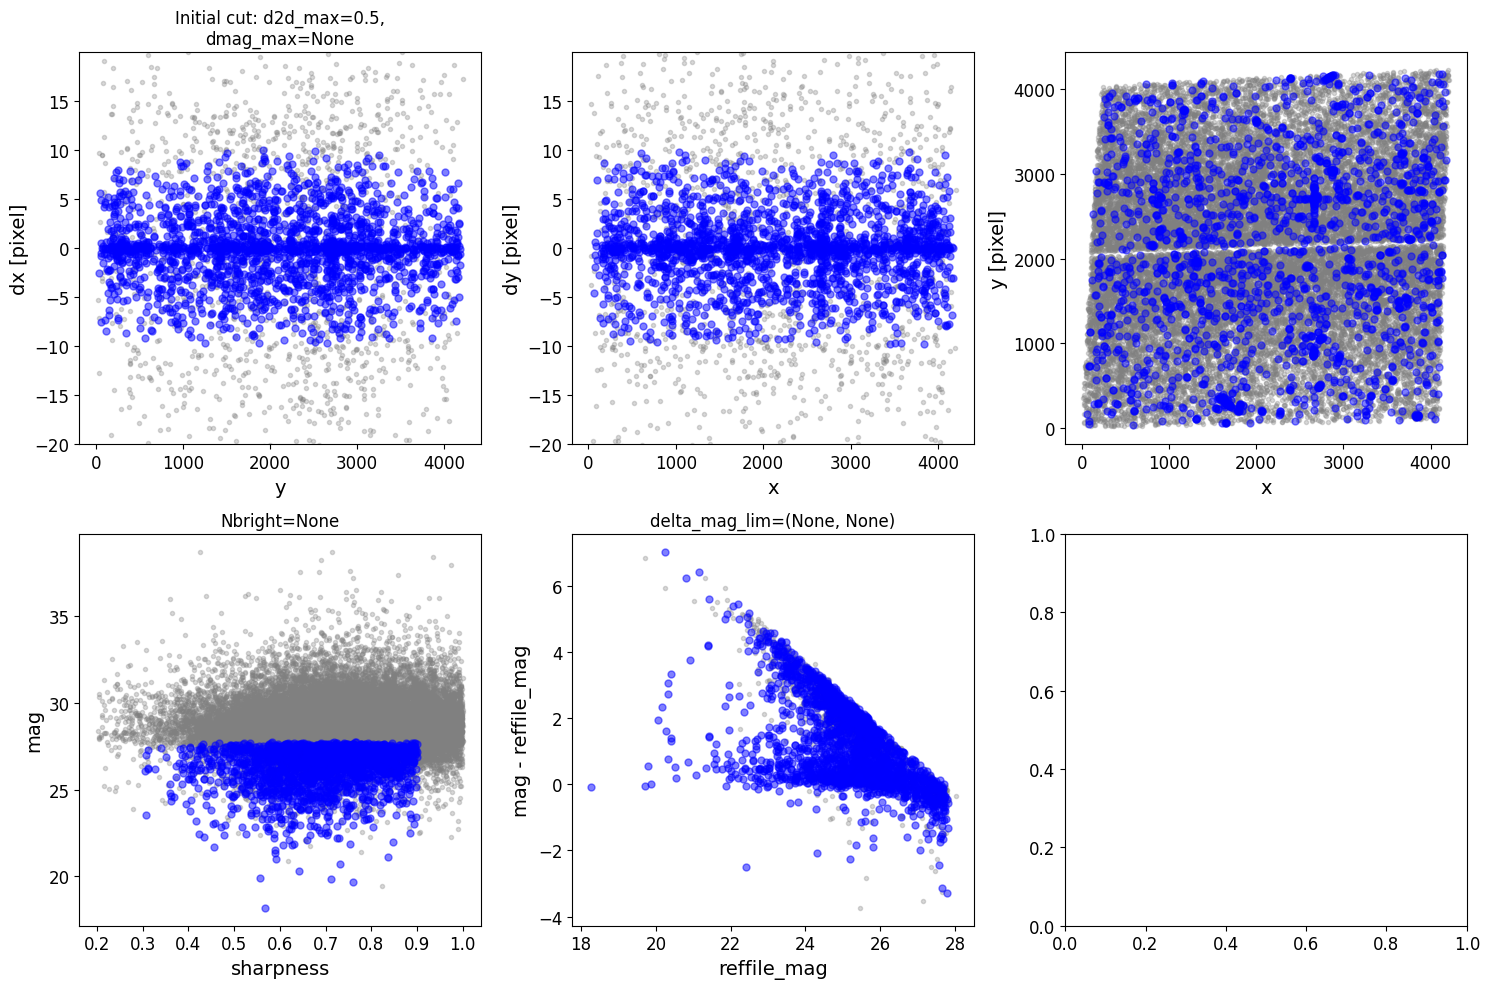

        slope    intercept     maxval  index  d_bestguess  fwhm  multimax
-1.734723e-17 1.776357e-14 338.970472    518     0.004335  0.96     False
d_rot_tmp 0.8043346601880892
Keeping 686 out of 686, skippin 0 because of null values in columns d_rot_tmp
median: -0.003622
75.000000 percentile cut: max residual for cut: 0.441453
__tmp_residuals 0.44145338553706087
median: -0.004848
i:00 mean:-0.004848(0.009551) stdev:0.216323(0.006747) X2norm:1.00 Nchanged:0 Ngood:514 Nclip:172

mean: -0.010189
i:01 mean:-0.010189(0.012153) stdev:0.302600(0.008586) X2norm:1.00 Nchanged:107 Ngood:621 Nclip:65

mean: -0.005005
i:02 mean:-0.005005(0.013917) stdev:0.364233(0.009833) X2norm:1.00 Nchanged:65 Ngood:686 Nclip:0

mean: -0.005005
i:03 mean:-0.005005(0.013917) stdev:0.364233(0.009833) X2norm:1.00 Nchanged:0 Ngood:686 Nclip:0


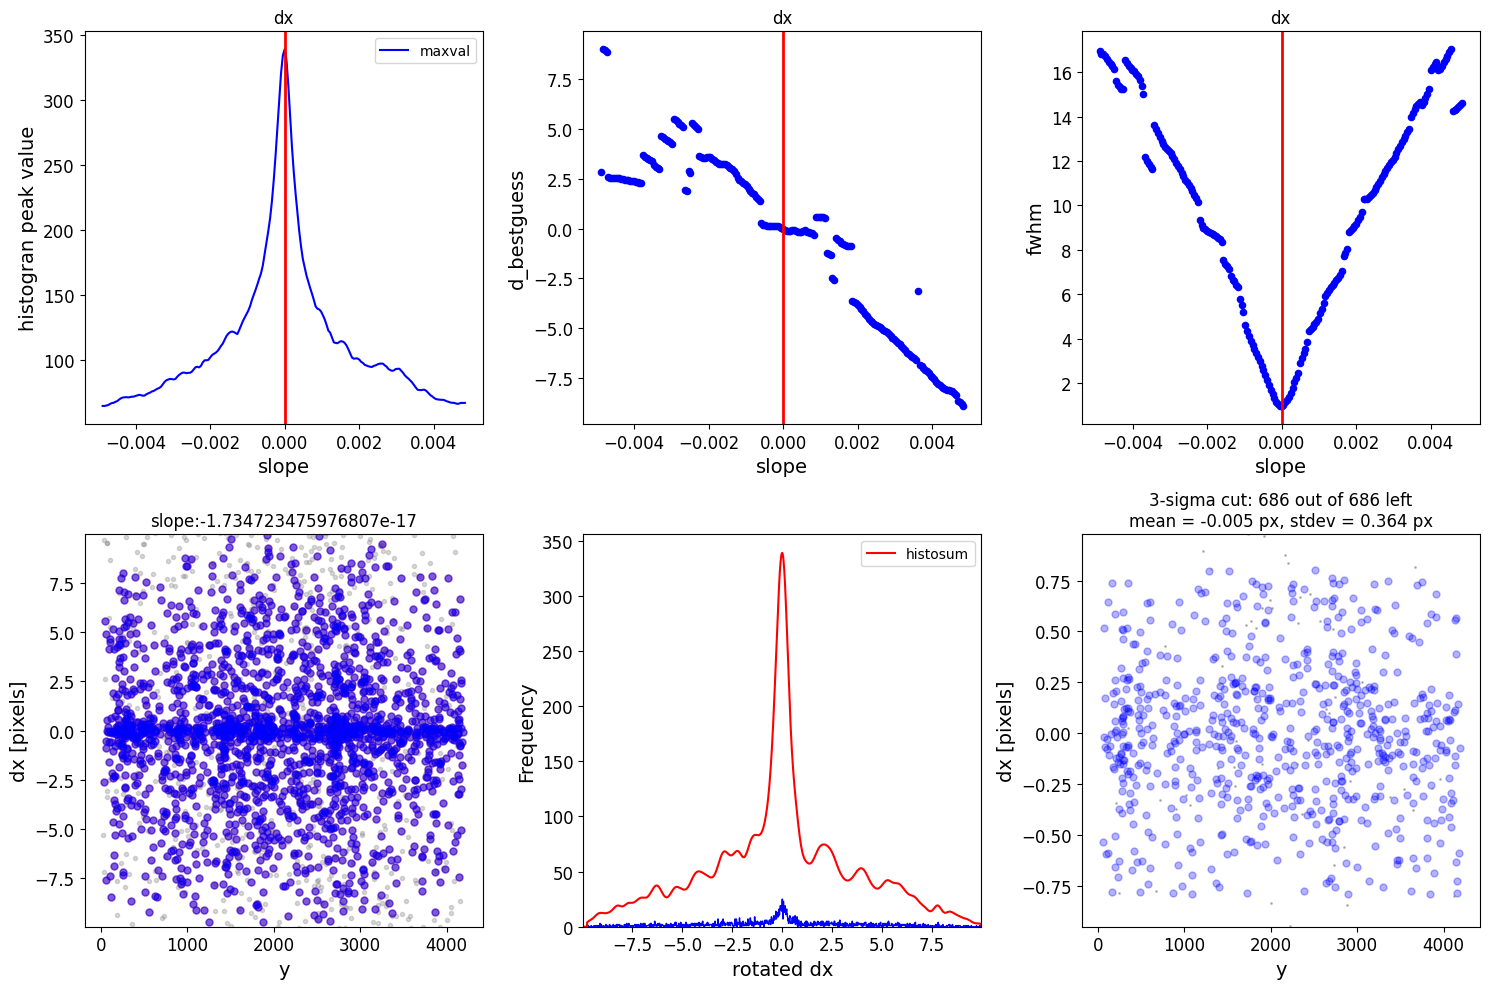

        slope    intercept     maxval  index  d_bestguess  fwhm  multimax
-1.734723e-17 3.552714e-14 244.450396    519    -0.000897   0.8     False
d_rot_tmp 0.7991025588704403
Keeping 442 out of 442, skippin 0 because of null values in columns d_rot_tmp
median: -0.005814
75.000000 percentile cut: max residual for cut: 0.410627
__tmp_residuals 0.41062666477786913
median: -0.004991
i:00 mean:-0.004991(0.010301) stdev:0.187132(0.007273) X2norm:1.00 Nchanged:0 Ngood:331 Nclip:111

mean: 0.002238
i:01 mean:0.002238(0.012662) stdev:0.247796(0.008942) X2norm:1.00 Nchanged:53 Ngood:384 Nclip:58

mean: -0.008769
i:02 mean:-0.008769(0.015256) stdev:0.315986(0.010775) X2norm:1.00 Nchanged:46 Ngood:430 Nclip:12

mean: -0.019034
i:03 mean:-0.019034(0.016024) stdev:0.336513(0.011318) X2norm:1.00 Nchanged:12 Ngood:442 Nclip:0

mean: -0.019034
i:04 mean:-0.019034(0.016024) stdev:0.336513(0.011318) X2norm:1.00 Nchanged:0 Ngood:442 Nclip:0


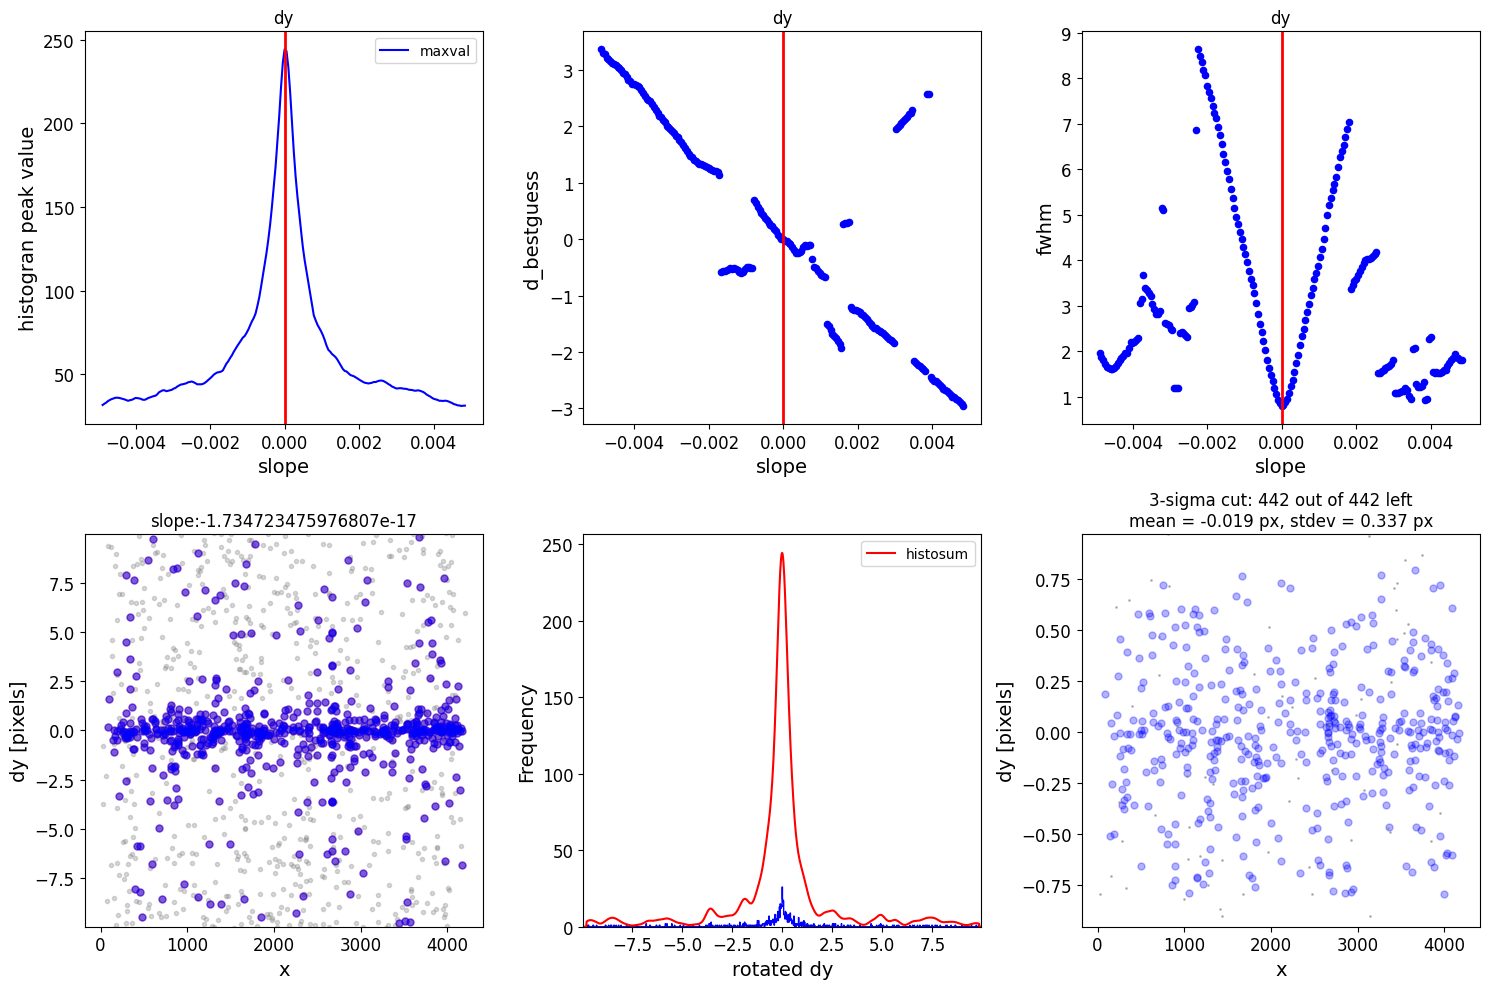

*** Note: close plots to continue!


<Figure size 640x480 with 0 Axes>

2024-07-10 19:15:40,507 - stpipe.TweakRegStep - INFO - TweakRegStep instance created.
2024-07-10 19:15:40,973 - stpipe.TweakRegStep - INFO - Step TweakRegStep running with args ([<JwstDataModel from jbqz24u1q_drc_sci.fits>],).
2024-07-10 19:15:40,978 - stpipe.TweakRegStep - INFO - Step TweakRegStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /home/aswin/hst123/jbqz24u1q_jhat.fits
  output_dir: ./.
  output_ext: .fits
  output_use_model: True
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_catalogs: False
  catalog_format: ecsv
  kernel_fwhm: 2.5
  snr_threshold: 50
  brightest: 4000
  peakmax: None
  enforce_user_order: False
  expand_refcat: False
  minobj: 4
  searchrad: 0.5
  use2dhist: True
  separation: 9
  tolerance: 0.7
  xoffset: 0
  yoffset: 0
  fitgeometry: general
  nclip: 3
  sigma: 3.0
  align_to_gaia: False
  gaia_catalog: GAIADR2
  min_gaia: 30
  save_gaia_catalog: False
  te

CRPIX1 2107.0 2107.0
CRPIX2 2118.5 2118.5
CUNIT1 deg deg
CUNIT2 deg deg
CRVAL1 31.417277642198837 31.417277215721
CRVAL2 -58.52173851202205 -58.521738623256
CRDER1 2.7815746914212e-06 2.7815746914212e-06
CRDER2 1.6444767648989e-06 1.6444767648989e-06
WCSNAME IDC_4bb1536cj-GSC240 IDC_4bb1536cj-GSC240
MJDREF 0.0 0.0
RADESYS ICRS ICRS

*** 'apply_tweak' version 3.5.1 started at 19:15:41.744 (10/07/2024): ***

Using WCS with WCSNAME 'IDC_4bb1536cj-GSC240' (WCS key ' ') for 'tweaked_wcs_name'

* Setting 'output_wcs_name' to 'IDC_4bb1536cj-GSC240'

* Working on input image /home/aswin/hst123/jbqz24u1q_jhat.fits ...


ValueError: Current value of 'output_wcs_name' was set to 'IDC_4bb1536cj-GSC240' by default. However, this WCS name value was already used in /home/aswin/hst123/jbqz24u1q_jhat.fits['SCI',2]. Please re-run 'apply_tweak' again and explicitly provide a unique value for the output WCS name.

In [27]:
wcs_align = st_wcs_align()


wcs_align.run_all('jbqz24u1q_flc.fits',
              telescope='hst',
              outsubdir='.',
          refcat_racol='ra',
          refcat_deccol='dec',
          refcat_magcol='mag',
          refcat_magerrcol='dmag',
          overwrite=True,
          d2d_max=.5,
          showplots=2,
          refcatname=ref_catname,
                  
          histocut_order='dxdy',
              sharpness_lim=(0.3,0.9),
              roundness1_lim=(-0.7, 0.7),
              SNR_min= 4,
              dmag_max=1.0)
#               objmag_lim =(14,24))

### Main

In [ ]:
  def run_tweakreg(self, obstable, reference, do_cosmic=True, skip_wcs=False,
#     search_radius=None, update_hdr=True):

#     if self.options['args'].work_dir:
#         outdir = self.options['args'].work_dir
#     else:
#         outdir = '.'

#     os.chdir(outdir)

#     # Get options from object
#     options = self.options['global_defaults']
#     # Check if tweakreg has already been run on each image
#     run_images = self.check_images_for_tweakreg(list(obstable['image']))
#     if not run_images: return('tweakreg success', None)
#     if reference in run_images: run_images.remove(reference)

#     # Records what the offsets are for the files run through tweakreg
#     shift_table = Table([run_images,[np.nan]*len(run_images),
#         [np.nan]*len(run_images)], names=('file','xoffset','yoffset'))

#     # Check if we just removed all of the images
#     if not run_images: #not needed
#         warning = 'WARNING: All images have been run through tweakreg.'
#         print(warning)
#         return(True)

#     print('Need to run tweakreg for images:')
#     self.input_list(obstable['image'], show=True, save=False)

#     tmp_images = []
#     for image in run_images:
#         if self.updatewcs and not skip_wcs:
#             det = '_'.join(self.get_instrument(image).split('_')[:2])
#             wcsoptions = self.options['detector_defaults'][det]
#             self.update_image_wcs(image, wcsoptions)

#         if not do_cosmic:
#             tmp_images.append(image)
#             continue

#         # wfc3_ir doesn't need cosmic clean and assume reference is cleaned
#         if (image == reference or 'wfc3_ir' in self.get_instrument(image)):
#             message = 'Skipping adjustments for {file} as WFC3/IR or reference'
#             print(message.format(file=image))
#             tmp_images.append(image)
#             continue

#         rawtmp = image.replace('.fits','.rawtmp.fits')
#         tmp_images.append(rawtmp)

#         # Check if rawtmp already exists
#         if os.path.exists(rawtmp):
#             message = '{file} exists. Skipping...'
#             print(message.format(file=rawtmp))
#             continue

#         # Copy the raw data into a temporary file
#         shutil.copyfile(image, rawtmp)

#         # Clean cosmic rays so they aren't used for alignment
#         inst = self.get_instrument(image).split('_')[0]
#         crpars = self.options['instrument_defaults'][inst]['crpars']
#         self.run_cosmic(rawtmp, crpars) #nircam l2 is cosmic ray corrected

#     modified = False
#     ref_images = self.pick_deepest_images(tmp_images)
#     deepest = sorted(ref_images, key=lambda im: fits.getval(im, 'EXPTIME'))[-1]
#     if (not reference or reference=='dummy.fits'):
#         reference = 'dummy.fits'
#         message = 'Copying {deep} to reference dummy.fits'
#         print(message.format(deep=deepest))
#         shutil.copyfile(deepest, reference)
#     elif not self.prepare_reference_tweakreg(reference):
#         # Can't use this reference image, just use one of the input
#         reference = 'dummy.fits'
#         message = 'Copying {deep} to reference dummy.fits'
#         print(message.format(deep=deepest))
#         shutil.copyfile(deepest, reference)
#     else:
#         modified = True

#     message = 'Tweakreg is executing...'
#     print(message)

#     start_tweak = time.time()

#     tweakreg_success = False
#     tweak_img = copy.copy(tmp_images)
#     ithresh = 10 ; rthresh = 10
#     shallow_img = []
#     thresh_data = None
#     tries = 0

#     while (not tweakreg_success and tries < 10):
#         tweak_img = self.check_images_for_tweakreg(tweak_img)
#         if not tweak_img: break
#         if tweak_img:
#             # Remove images from tweak_img if they are too shallow
#             if shallow_img:
#                 for img in shallow_img:
#                     if img in tweak_img:
#                         tweak_img.remove(img)

#             if len(tweak_img)==0:
#                 error = 'ERROR: removed all images as shallow'
#                 print(error)
#                 tweak_img = copy.copy(tmp_images)
#                 tweak_img = self.check_images_for_tweakreg(tweak_img)

#             # If we've tried multiple runs and there are images in input
#             # list with TWEAKSUC and reference image=dummy.fits, we might need
#             # to try a different reference image
#             success = list(set(tmp_images) ^ set(tweak_img))
#             if tries > 1 and reference=='dummy.fits' and len(success)>0:
#                 # Make random success image new dummy image
#                 n = len(success)-1
#                 shutil.copyfile(success[random.randint(0,n)],'dummy.fits')

#             # This estimates what the input threshold should be and cuts
#             # out images based on number of detected sources from previous
#             # rounds of tweakreg
#             message = '\n\nReference image: {ref} \n'
#             message += 'Images: {im}'
#             print(message.format(ref=reference, im=','.join(tweak_img)))

#             # Get deepest image and use threshold from that
#             deepest = sorted(tweak_img,
#                 key=lambda im: fits.getval(im, 'EXPTIME'))[-1]

#             if not thresh_data or deepest not in thresh_data['file']:
#                 inp_data = self.get_tweakreg_thresholds(deepest,
#                     options['nbright']*4)
#                 thresh_data = self.add_thresh_data(thresh_data, deepest,
#                     inp_data)
#             mask = thresh_data['file']==deepest
#             inp_thresh = thresh_data[mask][0]
#             print('Getting image threshold...')
#             new_ithresh = self.get_best_tweakreg_threshold(inp_thresh,
#                 options['nbright']*4)

#             if not thresh_data or reference not in thresh_data['file']:
#                 inp_data = self.get_tweakreg_thresholds(reference,
#                     options['nbright']*4)
#                 thresh_data = self.add_thresh_data(thresh_data, reference,
#                     inp_data)
#             mask = thresh_data['file']==reference
#             inp_thresh = thresh_data[mask][0]
#             print('Getting reference threshold...')
#             new_rthresh = self.get_best_tweakreg_threshold(inp_thresh,
#                 options['nbright']*4)

#             if not rthresh: rthresh = self.threshold
#             if not ithresh: ithresh = self.threshold

#             # Other input options
#             nbright = options['nbright']
#             minobj = options['minobj']
#             search_rad = int(np.round(options['search_rad']))
#             if search_radius: search_rad = search_radius

#             rconv = 3.5 ; iconv = 3.5 ; tol = 0.25
#             if 'wfc3_ir' in self.get_instrument(reference):
#                 rconv = 2.5
#             if all(['wfc3_ir' in self.get_instrument(i)
#                 for i in tweak_img]):
#                 iconv = 2.5 ; tol = 0.6
#             if 'wfpc2' in self.get_instrument(reference):
#                 rconv = 2.5
#             if all(['wfpc2' in self.get_instrument(i)
#                 for i in tweak_img]):
#                 iconv = 2.5 ; tol = 0.5


#             # Don't want to keep trying same thing over and over
#             if (new_ithresh>=ithresh or new_rthresh>=rthresh) and tries>1:
#                 # Decrease the threshold and increase tolerance
#                 message = 'Decreasing threshold and increasing tolerance...'
#                 print(message)
#                 ithresh = np.max([new_ithresh*(0.95**tries), 3.0])
#                 rthresh = np.max([new_rthresh*(0.95**tries), 3.0])
#                 tol = tol * 1.3**tries
#                 search_rad = search_rad * 1.2**tries
#             else:
#                 ithresh = new_ithresh
#                 rthresh = new_rthresh

#             if tries > 7:
#                 minobj = 7

#             message = '\nAdjusting thresholds:\n'
#             message += 'Reference threshold={rthresh}\n'
#             message += 'Image threshold={ithresh}\n'
#             message += 'Tolerance={tol}\n'
#             message += 'Search radius={rad}\n'
#             print(message.format(ithresh='%2.4f'%ithresh,
#                 rthresh='%2.4f'%rthresh, tol='%2.4f'%tol,
#                 rad='%2.4f'%search_rad))

#             outshifts = os.path.join(outdir, 'drizzle_shifts.txt')

#             try:
#                 tweakreg.TweakReg(files=tweak_img, refimage=reference,
#                     verbose=False, interactive=False, clean=True,
#                     writecat=True, updatehdr=update_hdr, reusename=True,
#                     rfluxunits='counts', minobj=minobj, wcsname='TWEAK',
#                     searchrad=search_rad, searchunits='arcseconds', runfile='',
#                     tolerance=tol, refnbright=nbright, nbright=nbright,
#                     separation=0.5, residplot='No plot', see2dplot=False,
#                     fitgeometry='shift',
#                     imagefindcfg = {'threshold': ithresh,
#                         'conv_width': iconv, 'use_sharp_round': True},
#                     refimagefindcfg = {'threshold': rthresh,
#                         'conv_width': rconv, 'use_sharp_round': True},
#                     shiftfile=True, outshifts=outshifts)

#                 # Reset shallow_img list
#                 shallow_img = []

#             except AssertionError as e:
#                 self.tweakreg_error(e)

#                 message = 'Re-running tweakreg with shallow images removed:'
#                 print(message)
#                 for img in tweak_img:
#                     nsources = self.get_nsources(img, ithresh)
#                     if nsources < 1000:
#                         shallow_img.append(img)

#             # Occurs when all images fail alignment
#             except TypeError as e:
#                 self.tweakreg_error(e)

#             # Record what the shifts are for each of the files run
#             message='Reading in shift file: {file}'
#             print(message.format(file=outshifts))
#             shifts = Table.read(outshifts, format='ascii', names=('file',
#                 'xoffset','yoffset','rotation1','rotation2','scale1','scale2'))

#             self.apply_tweakreg_success(shifts)

#             # Add data from output shiftfile to shift_table
#             for row in shifts:
#                 filename = os.path.basename(row['file'])
#                 filename = filename.replace('.rawtmp.fits','')
#                 filename = filename.replace('.fits','')

#                 idx = [i for i,row in enumerate(shift_table)
#                     if filename in row['file']]

#                 if len(idx)==1:
#                     shift_table[idx[0]]['xoffset']=row['xoffset']
#                     shift_table[idx[0]]['yoffset']=row['yoffset']

#             if not self.check_images_for_tweakreg(tmp_images):
#                 tweakreg_success = True

#             tries += 1

#     message = 'Tweakreg took {time} seconds to execute.\n\n'
#     print(message.format(time = time.time()-start_tweak))

#     print(shift_table)

    # tweakreg improperly indexes the CRVAL1 and CRVAL2 values
    # TODO: If drizzlepac fixes this then get rid of this code
    for image in tmp_images:
        rawtmp = image
        rawhdu = fits.open(rawtmp, mode='readonly')

        tweaksuc = False
        if ('TWEAKSUC' in rawhdu[0].header.keys() and
            rawhdu[0].header['TWEAKSUC']==1):
            tweaksuc = True

        if 'wfc3_ir' in self.get_instrument(image): continue

        for i,h in enumerate(rawhdu):
            if (tweaksuc and 'CRVAL1' in h.header.keys() and
                'CRVAL2' in h.header.keys()):
                rawhdu[i].header['CRPIX1']=rawhdu[i].header['CRPIX1']-0.5
                rawhdu[i].header['CRPIX2']=rawhdu[i].header['CRPIX2']-0.5

        rawhdu.writeto(rawtmp, overwrite=True)

    if not skip_wcs:
        for image in run_images:
            # Copy image over now to perform other image header updates
            if (image == reference or 'wfc3_ir' in self.get_instrument(image)):
                continue

            message = '\n\nUpdating image data for image: {im}'
            print(message.format(im=image))
            rawtmp = image.replace('.fits','.rawtmp.fits')

            rawhdu = fits.open(rawtmp, mode='readonly')
            hdu    = fits.open(image, mode='readonly')
            newhdu = fits.HDUList()

            print('Current image info:')
            hdu.info()

            for i, h in enumerate(hdu):
                if h.name=='SCI':
                    if 'flc' in image or 'flt' in image:
                        if len(rawhdu)>=i+2 and rawhdu[i+2].name=='DQ':
                            self.copy_wcs_keys(rawhdu[i], rawhdu[i+2])
                    elif 'c0m' in image:
                        maskfile = image.split('_')[0]+'_c1m.fits'
                        if os.path.exists(maskfile):
                            maskhdu = fits.open(maskfile)
                            self.copy_wcs_keys(rawhdu[i], maskhdu[i])
                            maskhdu.writeto(maskfile, overwrite=True)

                # Skip WCSCORR for WFPC2 as non-standard hdu
                if 'wfpc2' in self.get_instrument(image).lower():
                    if h.name=='WCSCORR':
                        continue

                # Get the index of the corresponding extension in rawhdu.  This
                # can be different from "i" if extensions were added or
                # rearranged
                ver = int(h.ver) ; name = str(h.name).strip()
                idx = -1

                for j,rawh in enumerate(rawhdu):
                    if str(rawh.name).strip()==name and int(rawh.ver)==ver:
                        idx = j

                # If there is no corresponding extension, then continue
                if idx < 0:
                    message = 'Skip extension {i},{ext},{ver} '
                    message += '- no match in {f}'
                    print(message.format(i=i, ext=name, ver=ver, f=rawtmp))
                    continue

                # If we can access the data in both extensions, copy from
                if h.name!='DQ':
                    if 'data' in dir(h) and 'data' in dir(rawhdu[idx]):
                        if (rawhdu[idx].data is not None and
                            h.data is not None):
                            if rawhdu[idx].data.dtype==h.data.dtype:
                                rawhdu[idx].data = h.data

                # Copy the rawtmp extension into the new file
                message = 'Copy extension {i},{ext},{ver}'
                print(message.format(i=idx, ext=name, ver=ver))
                newhdu.append(copy.copy(rawhdu[idx]))

            if 'wfpc2' in self.get_instrument(image).lower():
                # Adjust number of extensions to 4
                newhdu[0].header['NEXTEND']=4

            print('\n\nNew image info:')
            newhdu.info()

            newhdu.writeto(image, output_verify='silentfix', overwrite=True)

            if (os.path.isfile(rawtmp) and not self.options['args'].cleanup):
                os.remove(rawtmp)

    # Clean up temporary files and output
    if os.path.isfile('dummy.fits'):
        os.remove('dummy.fits')

    if not self.options['args'].keep_objfile:
        for file in glob.glob('*.coo'):
            os.remove(file)

    if modified:
        # Re-sanitize reference using main sanitize function
        self.sanitize_reference(reference)

    return(tweakreg_success, shift_table)